# My Hough Line  Detection for CTIO

- author : Sylvie Dagoret-Campagne
- afflilation : LAL/IJCLab, CNRS
- creation date : January 10th 2020
- update : 
  - January 11th 2020 : My Hough line detection
  - January 13th 2020 : Draw my Aigrettes lines
  - January 14th 2020 : Fit Aigrettes lines with ODR
  - January 15th 2020 : Histo of lambda_min and minima & maxima search with find peaks + smoothing

In [331]:
import os
import re
import numpy as np

In [332]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') # vary depending on your lang/locale

'en_US.UTF-8'

In [333]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import LogNorm

In [334]:
import numpy as np
import re
import time
from datetime import datetime,date
import dateutil.parser

In [335]:
from math import ceil,floor
from astropy.time import Time
import astropy
from astropy.visualization.mpl_normalize import (ImageNormalize,MinMaxInterval,PercentileInterval,SqrtStretch,LogStretch)
from astropy.visualization.wcsaxes import SphericalCircle

In [336]:
matplotlib.rcParams.update({'font.size': 15, 'lines.linewidth': 2, 'lines.markersize': 15})
matplotlib.rcParams["axes.labelsize"]="small"
matplotlib.rcParams["axes.linewidth"]=2.0
matplotlib.rcParams["xtick.major.size"]=8
matplotlib.rcParams["ytick.major.size"]=8
matplotlib.rcParams["ytick.minor.size"]=5
matplotlib.rcParams["xtick.labelsize"]="large"
matplotlib.rcParams["ytick.labelsize"]="large"
matplotlib.rcParams["figure.figsize"]=(8,8)
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.titleweight'] = 'bold'
#matplotlib.rcParams['axes.facecolor'] = 'blue'
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
matplotlib.rcParams['lines.markersize'] = 10  # markersize, in points
matplotlib.rcParams['grid.alpha'] = 1. # transparency, between 0.0 and 1.0
matplotlib.rcParams['grid.linestyle'] = '-' # simple line
matplotlib.rcParams['grid.linewidth'] = 0.4 # in points 

In [337]:
import sys
sys.path.append("../..")
sys.path.append("../../FeaturesExtractor")
sys.path.append("../../FeaturesExtractor/features")

In [338]:
from FeaturesExtractor.config import *
from FeaturesExtractor.features.images import *
from FeaturesExtractor.features.features import *
from FeaturesExtractor.tools import *
from FeaturesExtractor import parameters

In [339]:
from skimage import feature

In [340]:
from skimage.feature import peak_local_max
from skimage.filters import sobel
from skimage import morphology

In [341]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line

In [342]:
from skimage.filters import gaussian

In [343]:
from scipy import odr

In [344]:
from scipy.signal import find_peaks

# Input file

In [345]:
datafiles=["CTIO_reduc_20170531_169.fits",
           "T1M_20190215_225811_838_HD116405_Filtre_None_bin1x1.5_red.fit",
           "T1M_20190215_194504_399_PNK448_Filtre_None_bin1x1.1_red.fit",
           "T1M_20190215_225847_115_HD116405_Filtre_None_bin1x1.6_red.fit",
           "T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit", 
           "T1M_20190215_225922_399_HD116405_Filtre_None_bin1x1.7_red.fit",
           "T1M_20190215_225626_007_HD116405_Filtre_None_bin1x1.2_red.fit",
           "T1M_20190215_225957_677_HD116405_Filtre_None_bin1x1.8_red.fit",
           "T1M_20190215_225701_284_HD116405_Filtre_None_bin1x1.3_red.fit",   
           "T1M_20190215_230032_956_HD116405_Filtre_None_bin1x1.9_red.fit",
           "T1M_20190215_225736_562_HD116405_Filtre_None_bin1x1.4_red.fit",   
           "T1M_20190215_230108_233_HD116405_Filtre_None_bin1x1.10_red.fit"]

In [346]:
inputdir="../../tests/data/"

In [347]:
fileindex=0

In [348]:
inputfile="../../tests/data/T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit"

In [349]:
inputfile=os.path.join(inputdir,datafiles[fileindex])

In [350]:
configfile='../../config/picdumidi.ini'

# Start

In [351]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")+"_ctio"

In [352]:
string_date

'2020-01-17_ctio'

In [353]:
#--------- Start Logger
my_logger = set_logger("TestCannyEdgesDetection")
my_logger.info('\n\tStart TestCannyEdgesDetection')

2020-01-17 13:38:41  TestCannyEdgesDetection <module>             INFO   
	Start TestCannyEdgesDetection


In [354]:
#--------- Load config file ---------------
load_config(configfile)

In [355]:
#-------- Load reduced image
image = Image(inputfile)

2020-01-17 13:38:41  Image      load_image           INFO   
	Image in file  ../../tests/data/CTIO_reduc_20170531_169.fits loaded


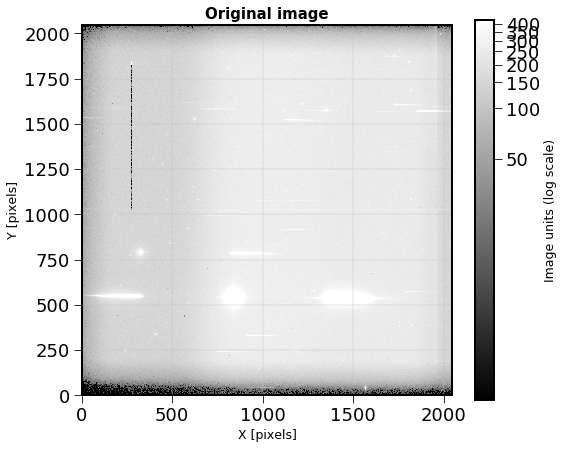

In [356]:
#if parameters.DEBUG and parameters.FLAG_PLOT_IMG :
if parameters.DEBUG  :
    image.plot_image(scale='log',title="Original image",cmap=plt.cm.gray)

In [357]:
#-----------------------------------------------------------------------------------------------------------
# Process the whole image by calculating Hessian, and its Eigen values images (lambda_plus and lambda_minus) and theta as well
#-----------------------------------------------------------------------------------------------------------
image.process_image()

2020-01-17 13:38:42  Image      process_image        INFO   
	Size of original image (Nx,Ny) = (2048,2048)
2020-01-17 13:38:42  Image      process_image        INFO   
	Size of processed image (Nx,Ny) = (2046,2046)
2020-01-17 13:38:42  Image      process_image        INFO   
	Padding of processed image (Xpad,Ypad)  = (1,1)
2020-01-17 13:38:42  Image      process_image        INFO   
	Image processed


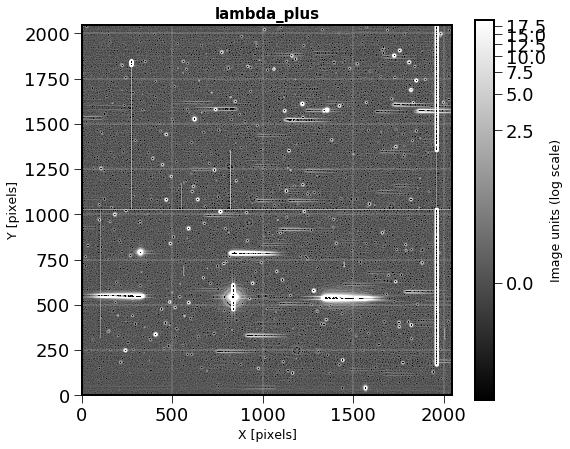

In [358]:
#if parameters.DEBUG and parameters.FLAG_PLOT_LAMBDA_PLUS:
if parameters.DEBUG :
    image.plot_image(img_type="lambda_p",scale='log',title="lambda_plus",cmap=plt.cm.gray)


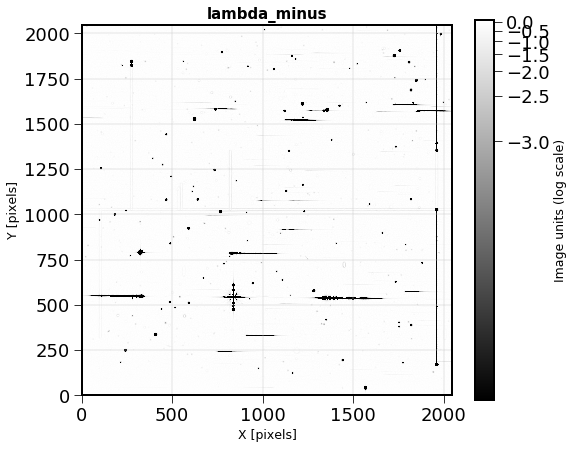

In [359]:
#if parameters.DEBUG and parameters.FLAG_PLOT_LAMBDA_MINUS:
if parameters.DEBUG:
    image.plot_image(img_type="lambda_m", scale='log', title="lambda_minus",cmap=plt.cm.gray)

In [360]:
# ----------------------------------------------------------------------------------------------------------
# Clip Minimal and maximal values inside the images
#------------------------------------------------------------------------------------------------------------
image.clip_images()

2020-01-17 13:38:43  Image      clip_images          INFO   
	Images clipped


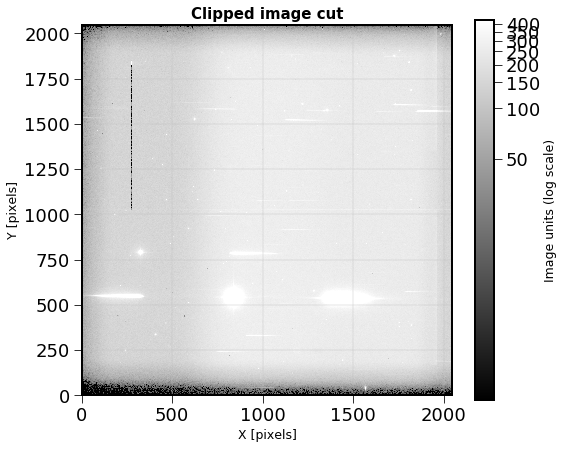

<Figure size 576x576 with 0 Axes>

In [361]:
#if parameters.DEBUG and parameters.FLAG_PLOT_IMG_CLIP:
if parameters.DEBUG :
    image.plot_image(img_type="img_cut",scale='log',title="Clipped image cut",cmap=plt.cm.gray)
    figname=string_date+"_imgoriginalclip_1.png"
    plt.savefig(figname)

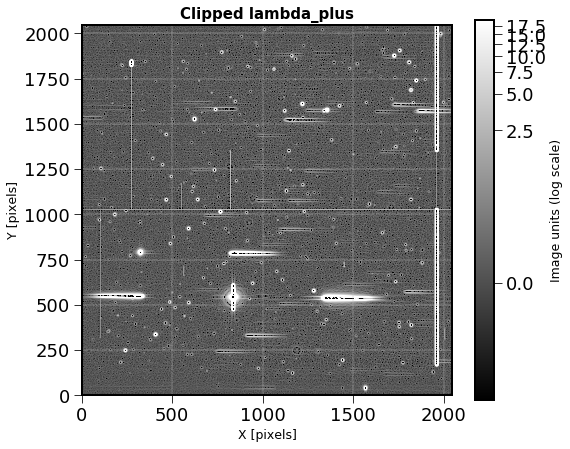

<Figure size 576x576 with 0 Axes>

In [362]:
#if parameters.DEBUG and parameters.FLAG_PLOT_LAMBDA_PLUS_CLIP:
if parameters.DEBUG :
    image.plot_image(img_type="lambda_p_cut",scale='log',title="Clipped lambda_plus",cmap=plt.cm.gray) 
    figname=string_date+"_imglambdaplusclip_1.png"
    plt.savefig(figname)

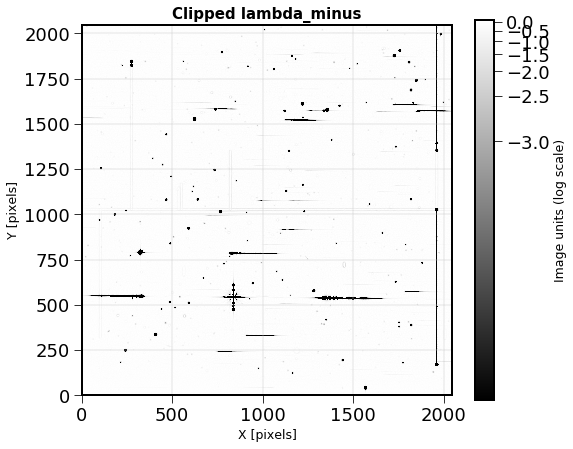

<Figure size 576x576 with 0 Axes>

In [363]:
#if parameters.DEBUG and parameters.FLAG_PLOT_LAMBDA_MINUS_CLIP:
if parameters.DEBUG :
    image.plot_image(img_type="lambda_m_cut", scale='log', title="Clipped lambda_minus",cmap=plt.cm.gray)
    figname=string_date+"_imglambdaminusclip_1.png"
    plt.savefig(figname)

In [364]:
#-------------------------------------------------------------------------------------------------------------
# Calculate edges inside the images on lambda_plus and lambda_minus
#-------------------------------------------------------------------------------------------------------------
image.compute_edges()   

2020-01-17 13:38:47  Image      compute_edges        INFO   
	Images edges computed


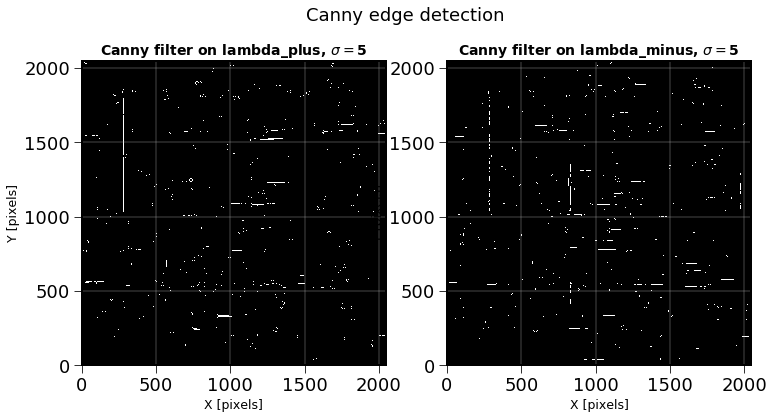

In [365]:
if parameters.DEBUG and ( parameters.FLAG_PLOT_LAMBDA_MINUS_EDGES or parameters.FLAG_PLOT_LAMBDA_PLUS_EDGES):
    image.plot_edges()

# Work with lambda\_minus

In [366]:
XMINSTAR=700
XMAXSTAR=1000
YMINSTAR=400
YMAXSTAR=700

In [367]:
#lambda_minus=np.copy(image.img_cube[parameters.IndexImg.lambda_minus])
lambda_minus=np.copy(image.img_cube[parameters.IndexImg.lambda_minus_clip])

main_title="lambda_minus clipped"

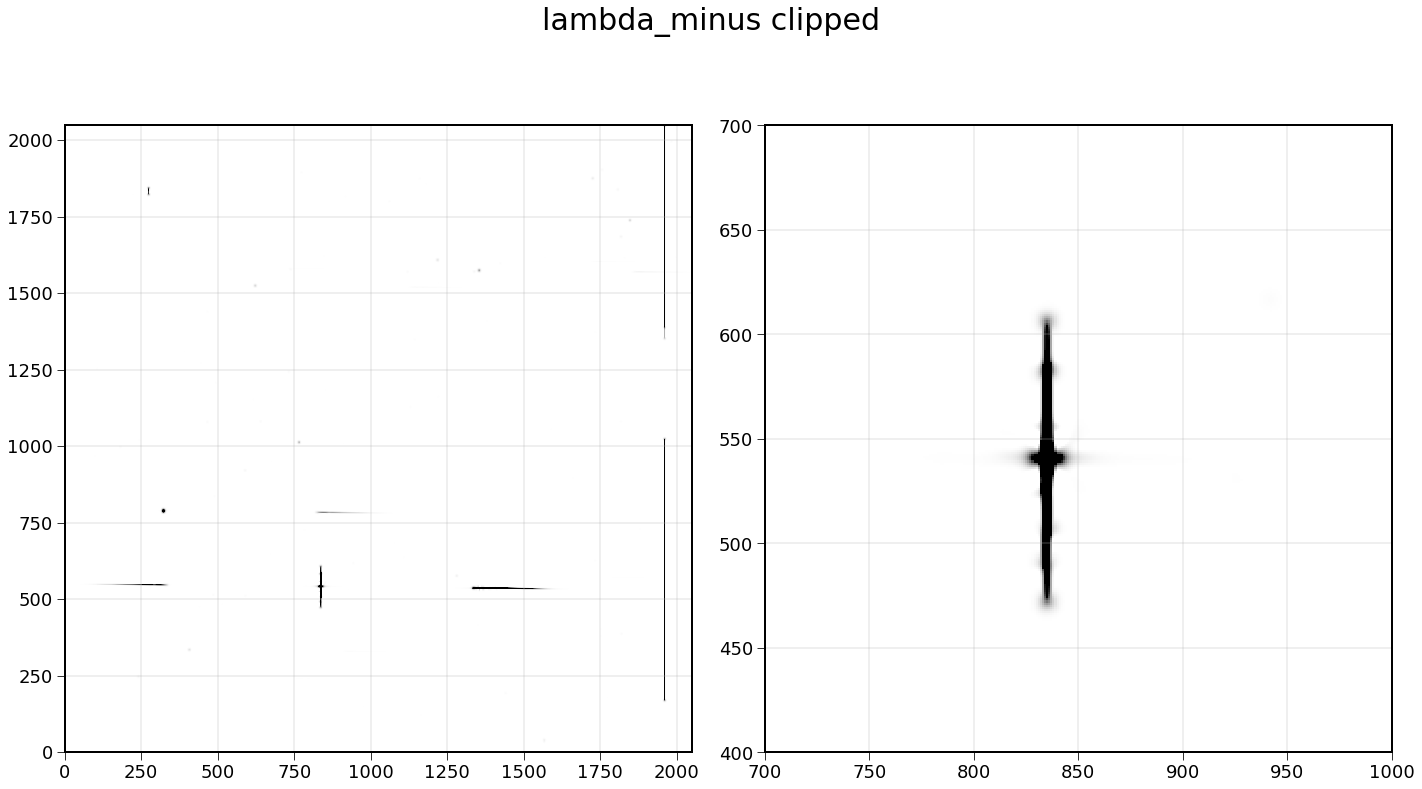

In [368]:
fig=plt.figure(figsize=(20,15))

vmin=lambda_minus.flatten().min()
vmax=lambda_minus.flatten().max()
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch())

plt.subplot(1,2,1)
img=plt.imshow(lambda_minus,origin="lower",cmap="gray",norm=norm)
plt.grid()
plt.subplot(1,2,2)
img=plt.imshow(lambda_minus,origin="lower",cmap="gray",norm=norm)
plt.xlim(XMINSTAR,XMAXSTAR)
plt.ylim(YMINSTAR,YMAXSTAR)
plt.grid()
plt.suptitle(main_title,fontsize=30,y=.9)
plt.tight_layout()
figname=string_date+"_imglambdaminus_2.png"
plt.savefig(figname)

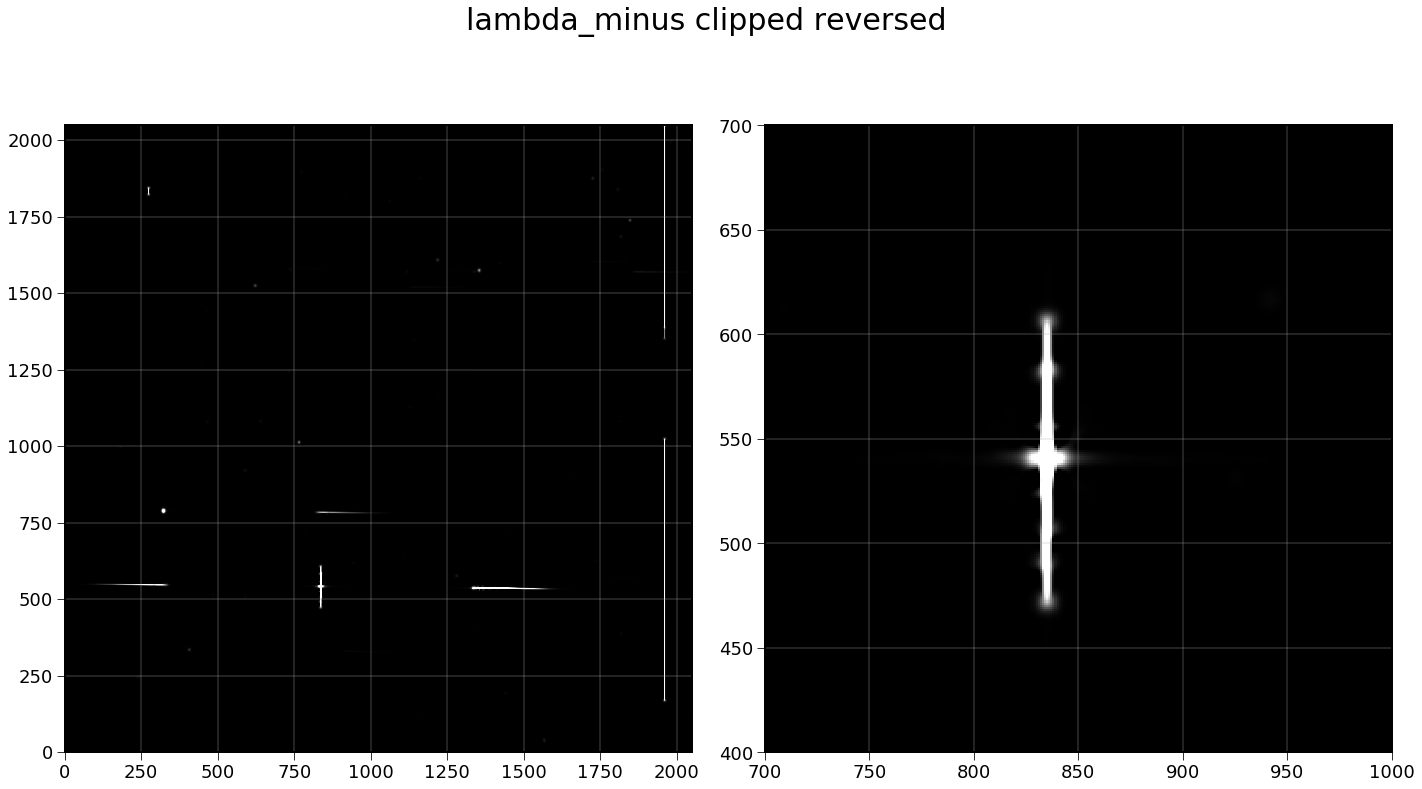

In [369]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
img=plt.imshow(-lambda_minus,origin="lower",cmap="gray")
plt.grid()
plt.subplot(1,2,2)
img=plt.imshow(-lambda_minus,origin="lower",cmap="gray")
plt.xlim(XMINSTAR,XMAXSTAR)
plt.ylim(YMINSTAR,YMAXSTAR)
plt.grid()
plt.suptitle(main_title+ " reversed ",fontsize=30,y=.9)
plt.tight_layout()
figname=string_date+"_imglambdaminus_3.png"
plt.savefig(figname)

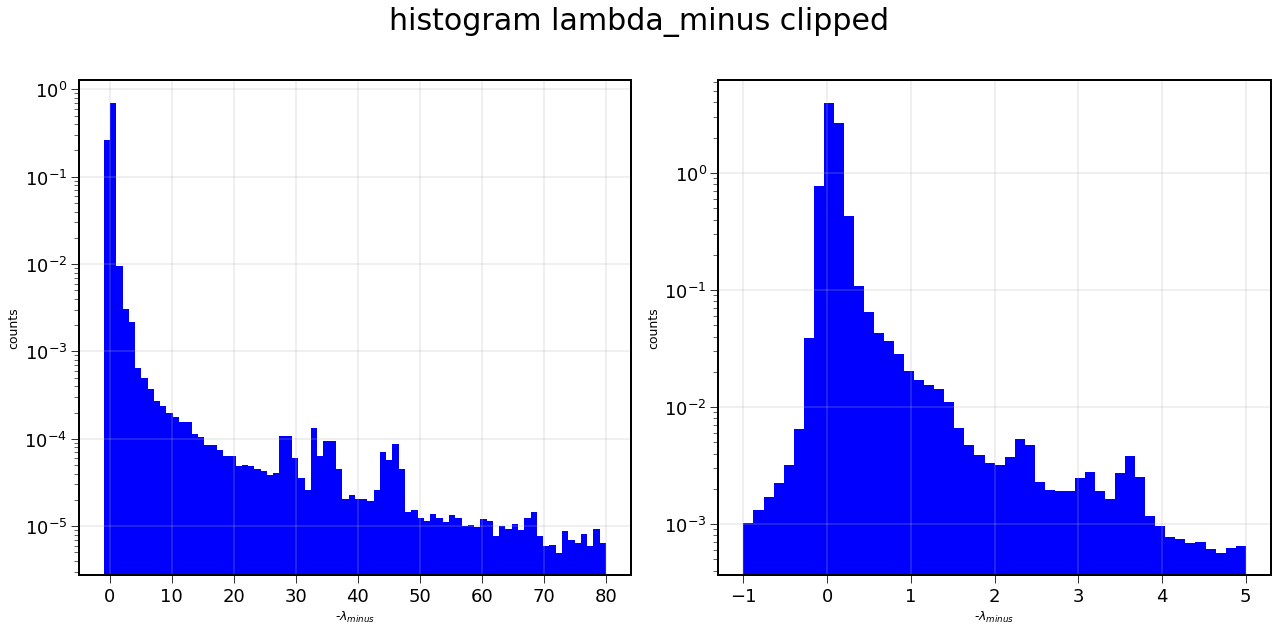

In [370]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.hist(-lambda_minus.flatten(),bins=80,range=(-1,80),density='True',facecolor="b");
plt.yscale('log')
plt.xlabel('-$\lambda_{minus}$')
plt.ylabel('counts')
plt.grid()
plt.subplot(1,2,2)
plt.hist(-lambda_minus.flatten(),bins=50,range=(-1,5),density='True',facecolor="b");
plt.yscale('log')
plt.xlabel('-$\lambda_{minus}$')
plt.ylabel('counts')
plt.grid()
plt.suptitle("histogram "+ main_title ,fontsize=30,y=1.1)
plt.tight_layout()
figname=string_date+"_histolambdaminus_1.png"
plt.savefig(figname)

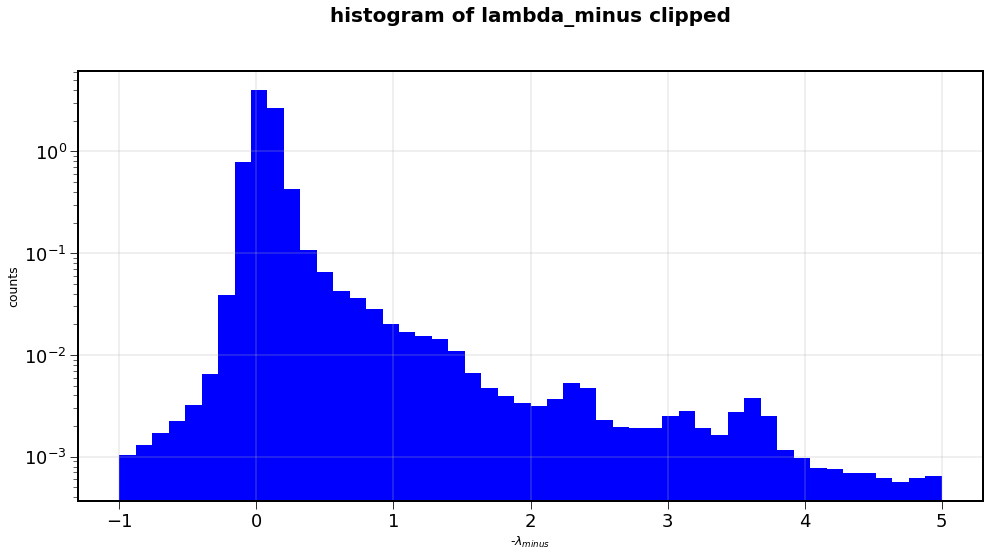

In [371]:
plt.figure(figsize=(14,8))
hist_data=plt.hist(-lambda_minus.flatten(),bins=50,range=(-1,5),density='True',facecolor='b');
plt.yscale('log')
plt.grid()
plt.xlabel('-$\lambda_{minus}$')
plt.ylabel('counts')
plt.title("histogram of "+ main_title ,fontsize=20,y=1.1)
plt.tight_layout()
figname=string_date+"_histolambdaminus_2.png"
plt.savefig(figname)

In [372]:
logcount,binval=np.log10(hist_data[0]),hist_data[1]

### Smoothing

In [373]:
# Choose the window size, odd, wnd>=3
window_len=5

In [374]:
smoothed_count=smooth(logcount,window_len=window_len)

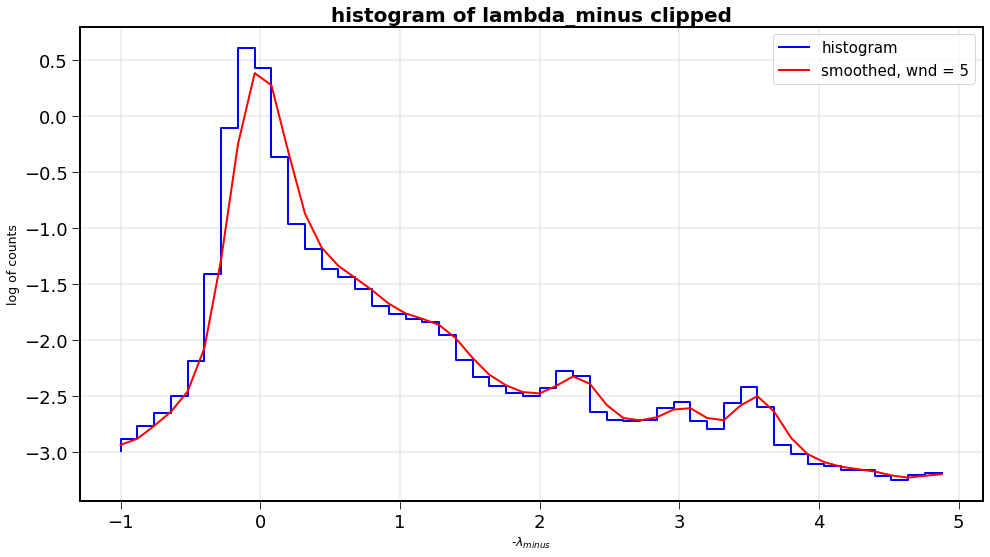

In [375]:
plt.figure(figsize=(14,8))
plt.step(binval[:-1],logcount,'b-',label="histogram")
label2 = "smoothed, wnd = {:d}".format(window_len)
plt.plot(binval[:-1],smoothed_count,'r-',label=label2)
plt.grid()
plt.xlabel('-$\lambda_{minus}$')
plt.ylabel('log of counts')
plt.title("histogram of "+ main_title ,fontsize=20,y=.999)
plt.legend(loc="upper right")
plt.tight_layout()
figname=string_date+"_histolambdaminus_3.png"
plt.savefig(figname)

### Search extrema

In [376]:
all_maxima=find_peaks(smoothed_count)[0]
all_minima=find_peaks(-smoothed_count)[0]

In [377]:
all_maxima

array([ 8, 27, 34, 38])

In [378]:
all_minima

array([25, 31, 36, 47])

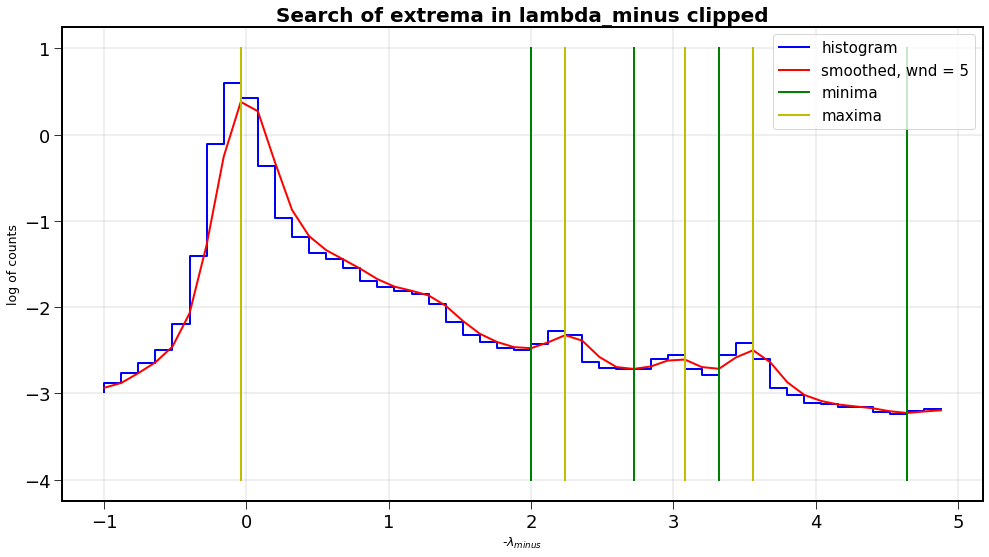

In [379]:
LOGCOUNTMIN = -4
LOGCOUNTMAX = 1

plt.figure(figsize=(14,8))
plt.step(binval[:-1],logcount,'b-',label="histogram")
label2 = "smoothed, wnd = {:d}".format(window_len)
plt.plot(binval[:-1],smoothed_count,'r-',label=label2)
plt.grid()

index=0
for minima in all_minima:
    x_min=binval[minima]
    if index==0:
        plt.plot([x_min,x_min],[LOGCOUNTMIN,LOGCOUNTMAX],"g-",label="minima")
    else:
        plt.plot([x_min,x_min],[LOGCOUNTMIN,LOGCOUNTMAX],"g-")
    index+=1

index=0    
for maxima in all_maxima:
    x_min=binval[maxima]
    if index==0:
        plt.plot([x_min,x_min],[LOGCOUNTMIN,LOGCOUNTMAX],"y-",label="maxima")
    else:
        plt.plot([x_min,x_min],[LOGCOUNTMIN,LOGCOUNTMAX],"y-")
    index+=1
    
plt.legend(loc="upper right")
plt.xlabel('-$\lambda_{minus}$')
plt.ylabel('log of counts')
plt.title("Search of extrema in "+ main_title ,fontsize=20,y=.999)
plt.tight_layout()
figname=string_date+"_histolambdaminus_4.png"
plt.savefig(figname)

In [380]:
peak_lm_minima=binval[all_minima]
peak_lm_minima

array([2.  , 2.72, 3.32, 4.64])

In [381]:
peak_lm_maxima=binval[all_maxima]
peak_lm_maxima

array([-0.04,  2.24,  3.08,  3.56])

# algo


https://scikit-image.org/docs/dev/auto_examples/applications/plot_coins_segmentation.html#sphx-glr-auto-examples-applications-plot-coins-segmentation-py

https://scikit-image.org/docs/dev/auto_examples/applications/plot_coins_segmentation.html#sphx-glr-auto-examples-applications-plot-coins-segmentation-py

## Sobel algorithm

- The Sobel algorithm has the advantage of not having any threshold to tune

In [382]:
edges= sobel(lambda_minus) 

In [383]:
#sobel?

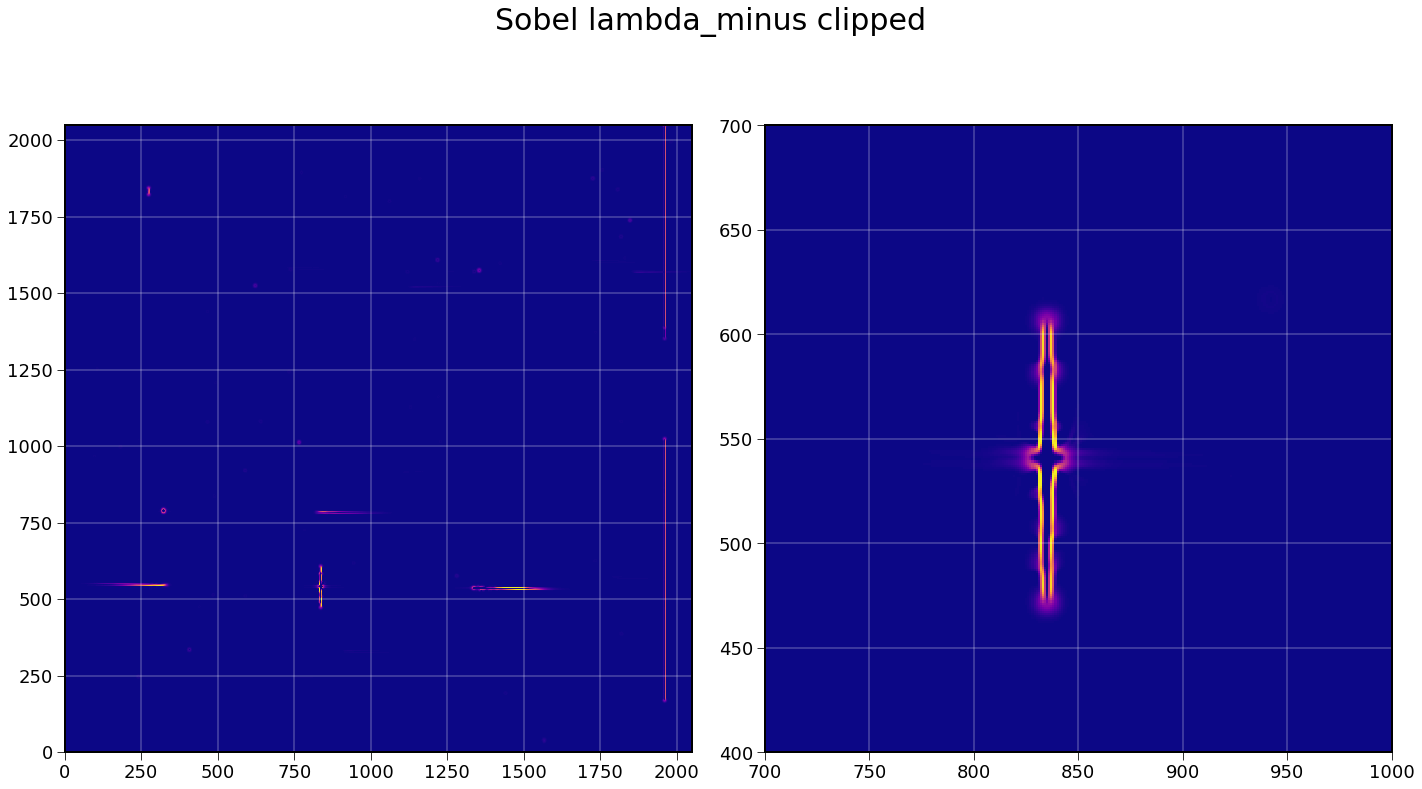

In [384]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(edges,origin="lower",cmap=plt.cm.plasma)
plt.grid(color="w")
plt.subplot(1,2,2)
plt.imshow(edges,origin="lower",cmap=plt.cm.plasma)
plt.xlim(XMINSTAR,XMAXSTAR)
plt.ylim(YMINSTAR,YMAXSTAR)
plt.grid(color="w")
plt.suptitle("Sobel "+ main_title ,fontsize=30,y=0.9)
plt.tight_layout()

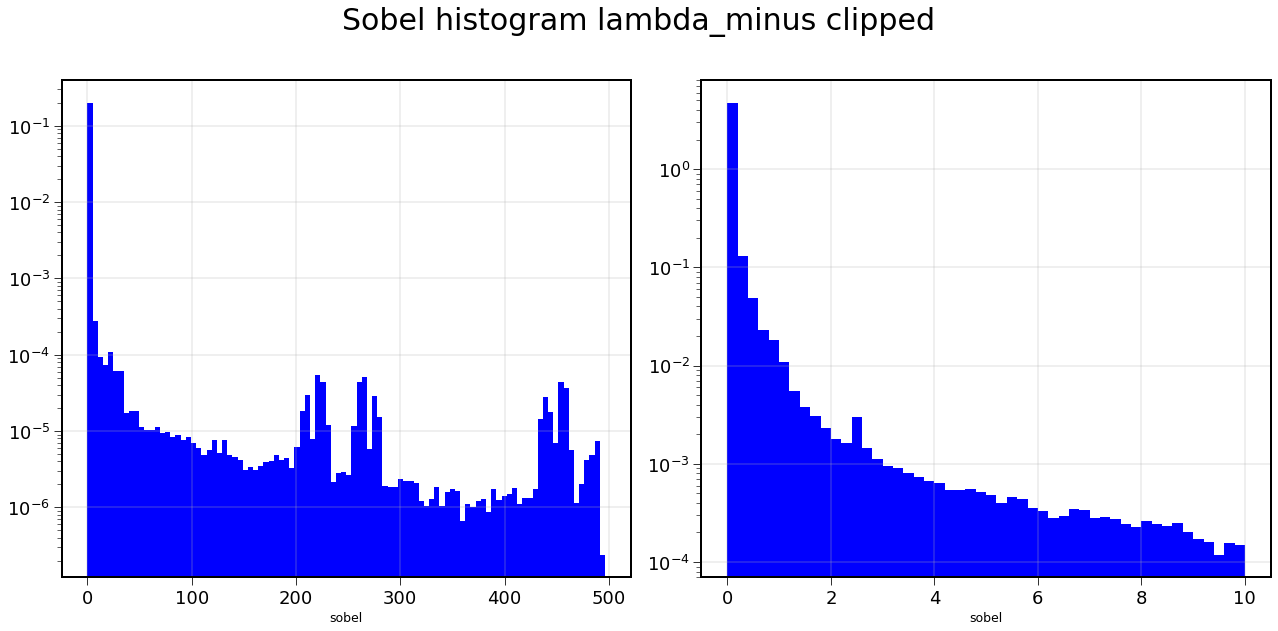

In [385]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.hist(edges.flatten(),bins=100,density='True',facecolor='b')
plt.yscale('log')
plt.xlabel('sobel')
plt.grid()
plt.subplot(1,2,2)
plt.hist(edges.flatten(),bins=50,range=(0,10),density='True',facecolor="b")
plt.yscale('log')
plt.xlabel('sobel')
plt.grid()
plt.suptitle("Sobel histogram "+ main_title ,fontsize=30,y=1.1)
plt.tight_layout()

In [386]:
markers = np.zeros_like(edges)
markers[edges >= 0 ] = 0
markers[edges >= 1 ] = 1   # all points for markers = 0 or 1 will be erased
markers[edges >  4 ] = 2    # all point above this threshold wil be kept
markers[edges > 10 ] = 3
markers[edges > 20] = 4
markers[edges > 30] = 5

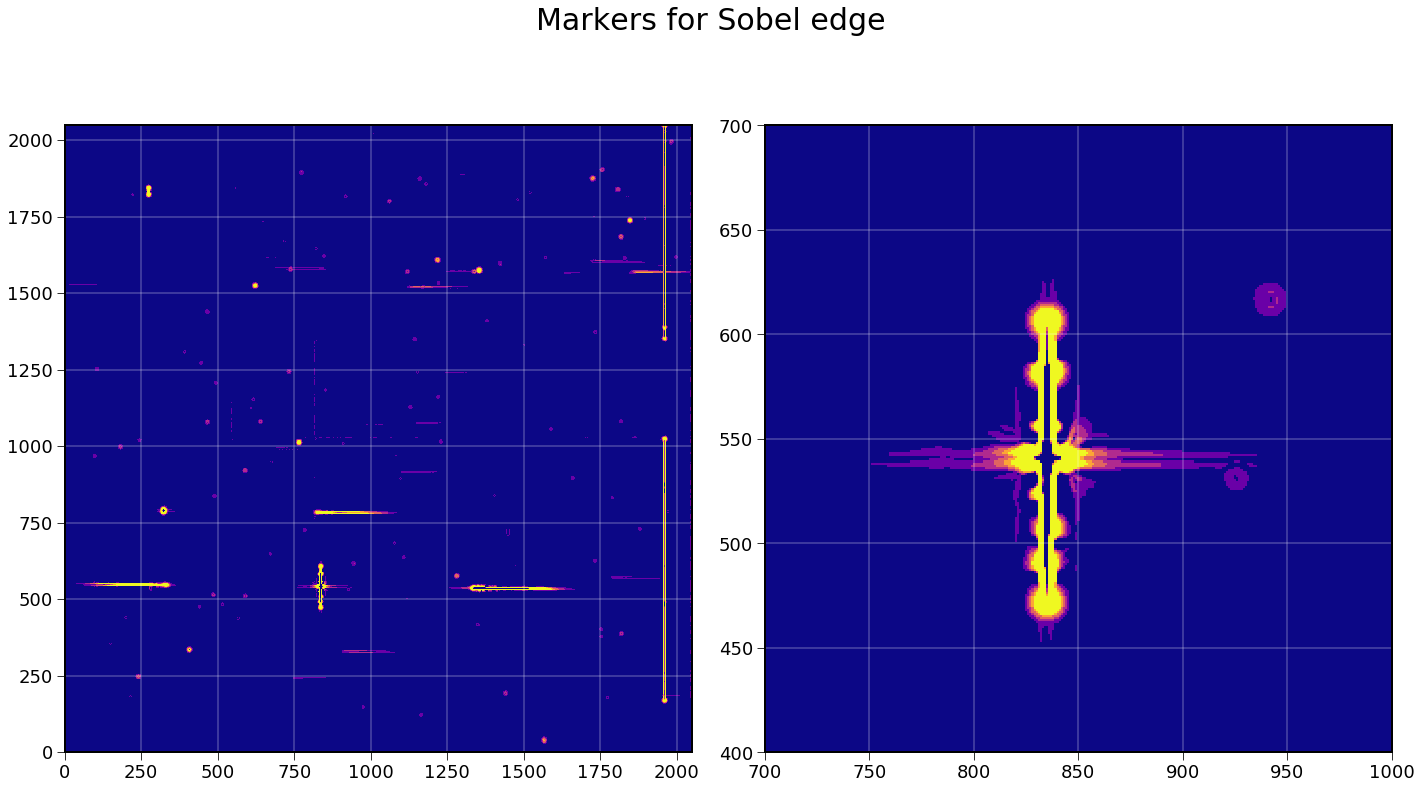

In [387]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(markers, origin="lower",cmap=plt.cm.plasma)
plt.grid(color="w")
plt.subplot(1,2,2)
plt.imshow(markers,origin="lower",cmap=plt.cm.plasma)
plt.grid(color="w")
plt.xlim(XMINSTAR,XMAXSTAR)
plt.ylim(YMINSTAR,YMAXSTAR)
plt.suptitle("Markers for Sobel edge" , fontsize=30,y=.9)
plt.tight_layout()

## Masking in slices of lambda

- Use -lambda_minus to defines markers

In [388]:
# Old fashion markers

In [389]:
markers = np.zeros_like(lambda_minus)
markers[-lambda_minus >=0 ] = 0
markers[-lambda_minus >=0.1 ] = 1   # all points for markers = 0 or 1 will be erased
#markers[-lambda_minus > 0.5] = 2    # all point above this threshold wil be kept
markers[-lambda_minus > 1.5] = 2    # all point above this threshold wil be kept
markers[-lambda_minus > 2 ] = 3
markers[-lambda_minus > 10] = 4
markers[-lambda_minus > 30] = 5

In [390]:
peak_lm_minima

array([2.  , 2.72, 3.32, 4.64])

In [391]:
peak_lm_maxima

array([-0.04,  2.24,  3.08,  3.56])

In [392]:
#markers = np.zeros_like(lambda_minus)
#markers[-lambda_minus >= 0 ] = 0
#markers[-lambda_minus >= peak_lm_maxima[0] ] = 1   # all points for markers = 0 or 1 will be erased
#markers[-lambda_minus >  peak_lm_minima[0] ] = 2    # all point above this threshold wil be kept
#markers[-lambda_minus >  peak_lm_minima[1] ] = 3
#markers[-lambda_minus >  peak_lm_minima[2] ] = 4
#markers[-lambda_minus >  peak_lm_minima[3] ] = 5

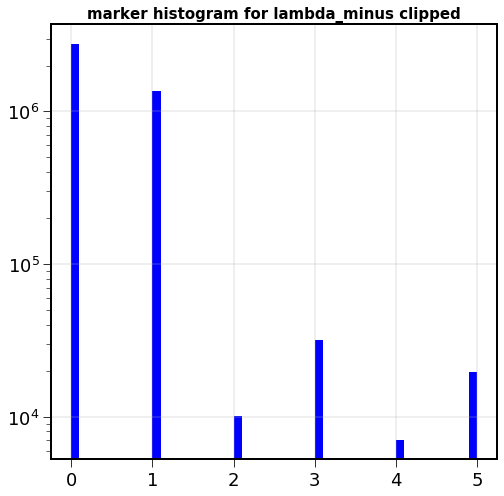

In [393]:
plt.hist(markers.flatten(),bins=50,facecolor='b')
plt.yscale('log')
plt.title("marker histogram for "+ main_title )
plt.grid()

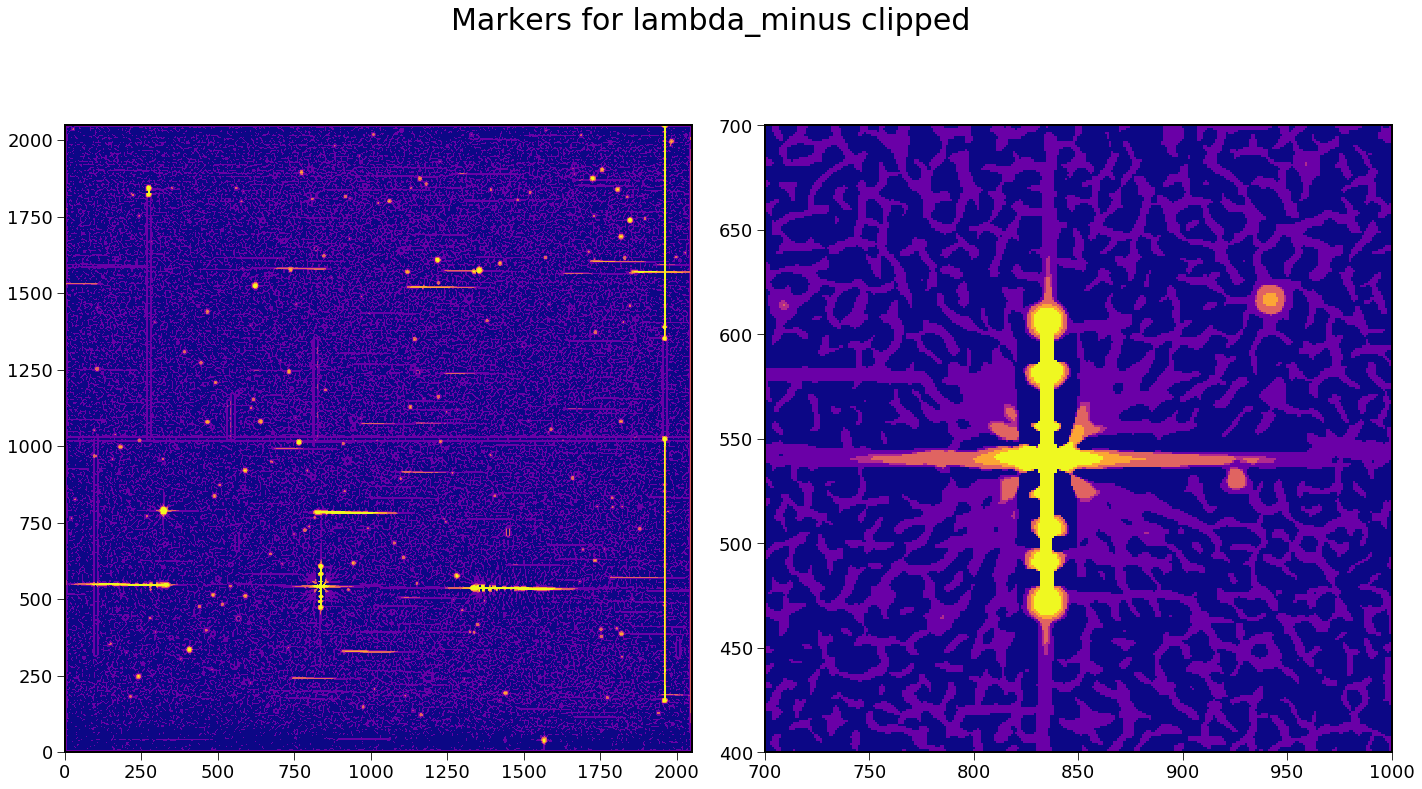

In [394]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(markers, origin="lower",cmap=plt.cm.plasma)
plt.subplot(1,2,2)
plt.imshow(markers,origin="lower",cmap=plt.cm.plasma)
plt.xlim(XMINSTAR,XMAXSTAR)
plt.ylim(YMINSTAR,YMAXSTAR)
plt.grid(color="w")
plt.suptitle("Markers for "+ main_title , fontsize=30,y=.9)
plt.grid()
plt.tight_layout()
figname=string_date+"_markers_1.png"
plt.savefig(figname)

## Segmentation with watershed

- use Sobel + Markers

In [395]:
segmentation = morphology.watershed(edges, markers)

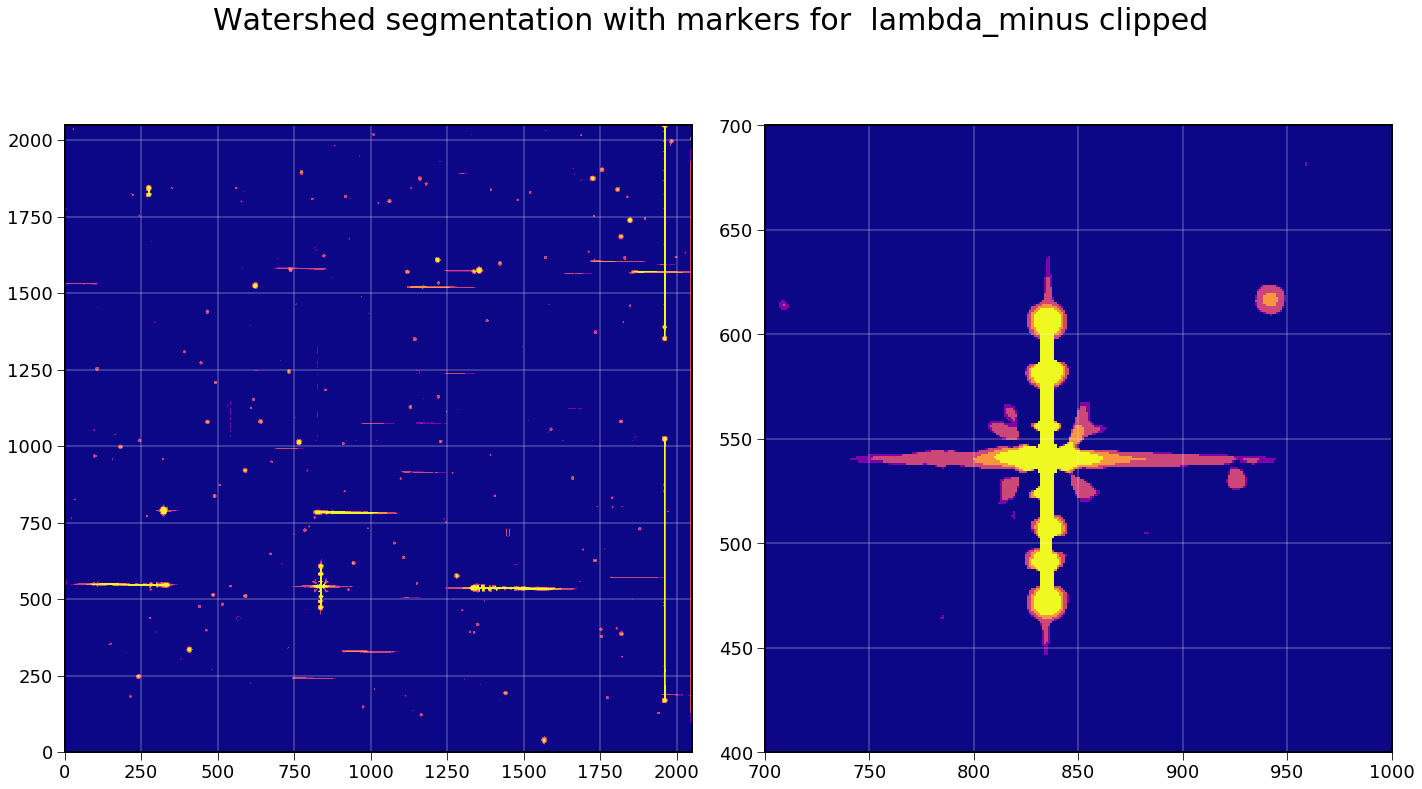

In [396]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(segmentation, origin="lower",cmap=plt.cm.plasma)
plt.grid(color="w")
plt.subplot(1,2,2)
plt.imshow(segmentation,origin="lower",cmap=plt.cm.plasma)
plt.xlim(XMINSTAR,XMAXSTAR)
plt.ylim(YMINSTAR,YMAXSTAR)
plt.grid(color="w")
plt.suptitle("Watershed segmentation with markers for  "+ main_title , fontsize=30,y=.9)
plt.tight_layout()
figname=string_date+"_markers_2.png"
plt.savefig(figname)

Text(0.5, 1.0, 'histogram of segmentation for lambda_minus clipped')

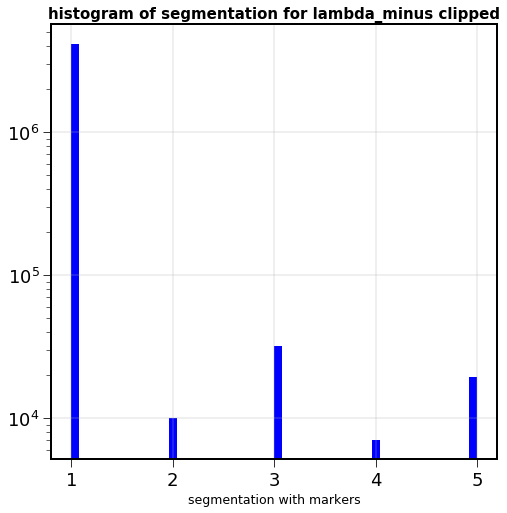

In [397]:
plt.hist(segmentation.flatten(),bins=50,facecolor='b')
plt.yscale('log')
plt.grid()
plt.xlabel('segmentation with markers')
plt.title("histogram of segmentation for " +main_title)

## Selection of Aigrettes

In [398]:
selection = np.where(segmentation==2,1,0)

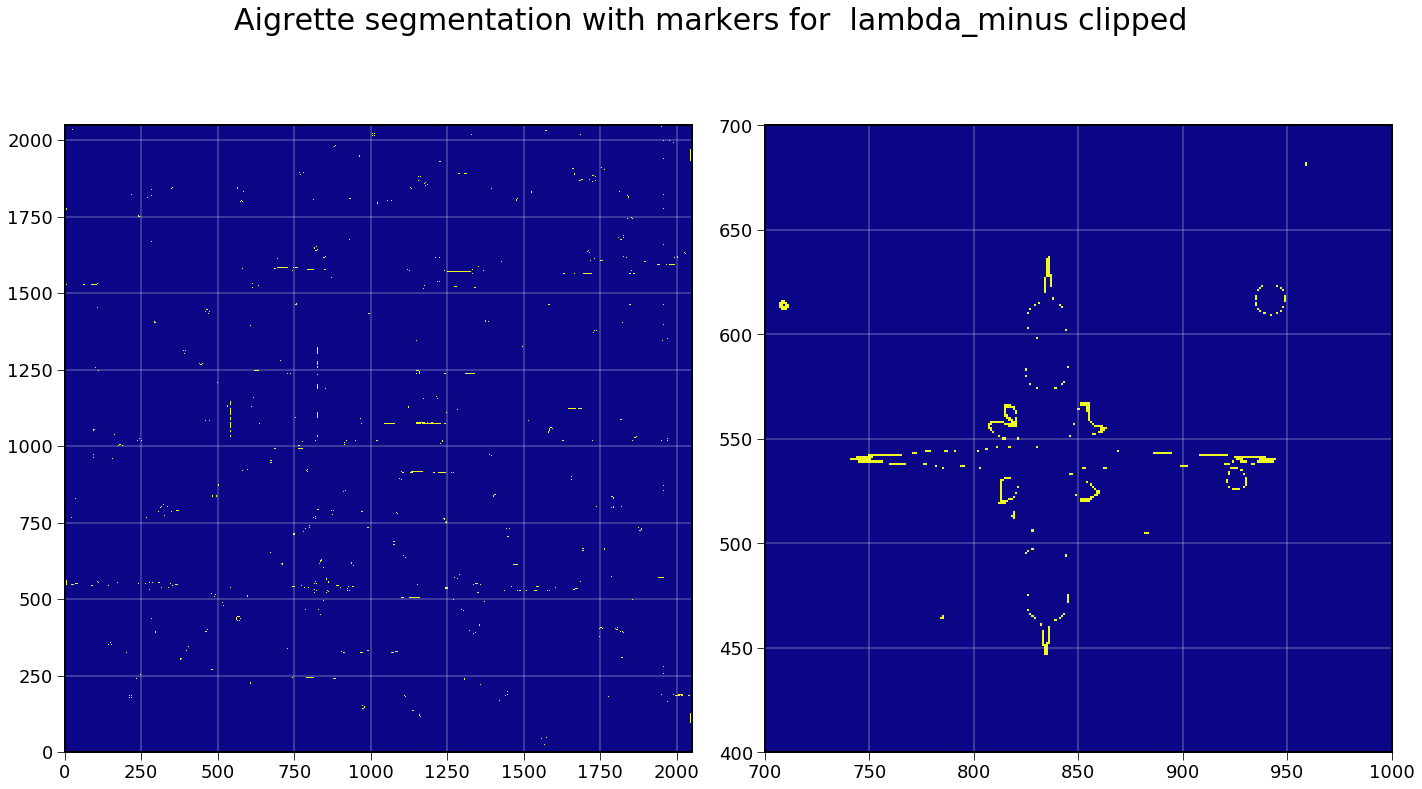

In [399]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
#plt.imshow(selection, origin="lower",cmap=plt.cm.jet)
plt.imshow(selection, origin="lower",cmap=plt.cm.plasma)
plt.grid(color="w")
plt.subplot(1,2,2)
#plt.imshow(selection,origin="lower",cmap=plt.cm.jet)
plt.imshow(selection,origin="lower",cmap=plt.cm.plasma)
plt.xlim(XMINSTAR,XMAXSTAR)
plt.ylim(YMINSTAR,YMAXSTAR)
plt.grid(color="w")
plt.suptitle("Aigrette segmentation with markers for  "+ main_title , fontsize=30,y=.9)
figname=string_date+"_markers_3.png"
plt.tight_layout()
plt.savefig(figname)

# clean borders

In [400]:
margin=10

In [401]:
selection[:margin,:]=0
selection[-margin:,:]=0
selection[:,:margin]=0
selection[:,-margin:]=0

In [402]:
selection[570:590,700:760] = 0 # clean

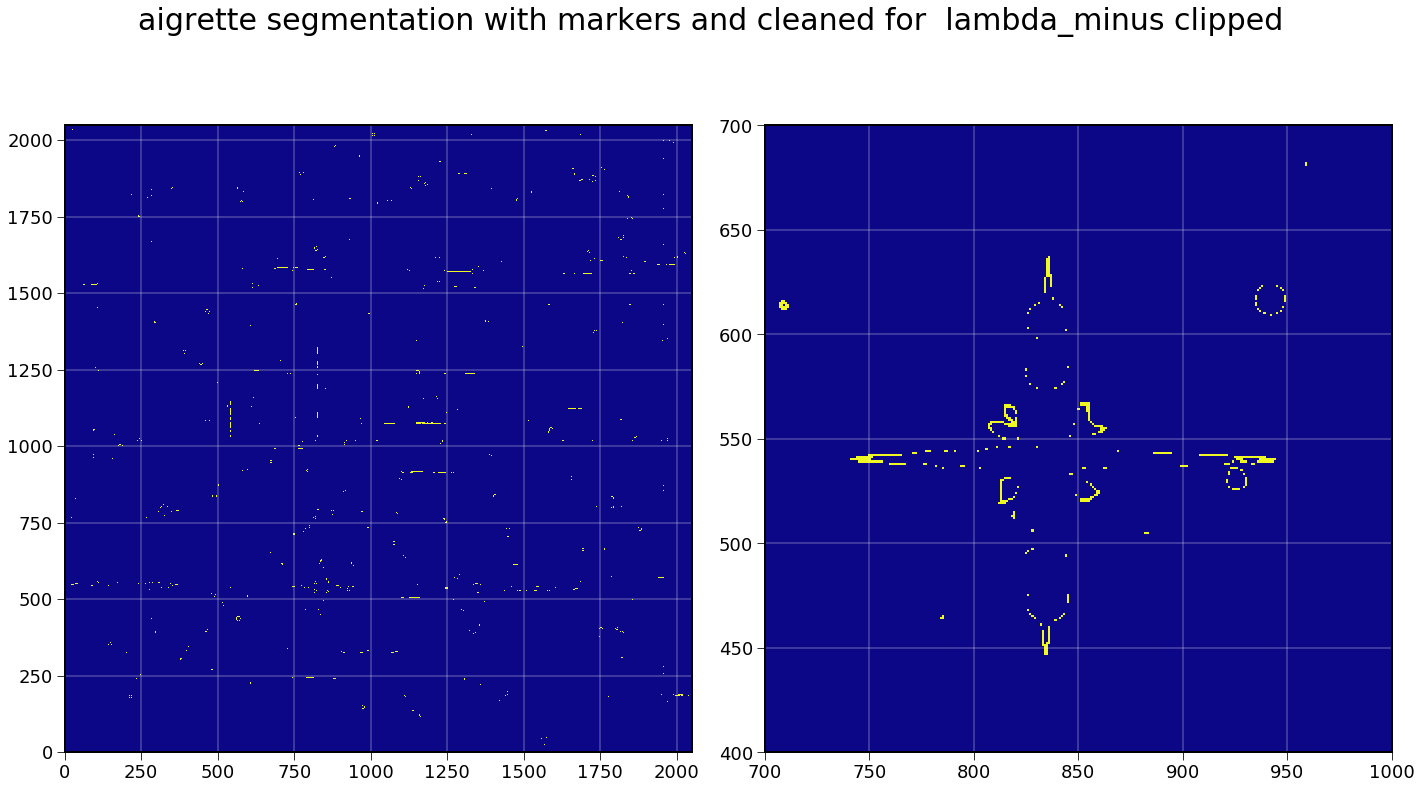

In [403]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
#plt.imshow(selection, origin="lower",cmap=plt.cm.jet)
plt.imshow(selection, origin="lower",cmap=plt.cm.plasma)
plt.grid(color="w")
plt.subplot(1,2,2)
#plt.imshow(selection,origin="lower",cmap=plt.cm.jet)
plt.imshow(selection,origin="lower",cmap=plt.cm.plasma)
plt.xlim(XMINSTAR,XMAXSTAR)
plt.ylim(YMINSTAR,YMAXSTAR)
plt.grid(color="w")
plt.suptitle("aigrette segmentation with markers and cleaned for  "+ main_title , fontsize=30,y=.9)
figname=string_date+"_markers_4.png"
plt.tight_layout()
plt.savefig(figname)

# Hough Line Detection

In [404]:
theta_deg=np.arange(-90,91,1)

In [405]:
theta_rad=np.radians(theta_deg)

In [406]:
NBAng=len(theta_rad)

In [407]:
aigrettes = selection[YMINSTAR:YMAXSTAR,XMINSTAR:XMAXSTAR]

In [408]:
# vector containing the points of aigrettes
Y,X=np.where(aigrettes==1)

In [409]:
NBPoints=len(X)

In [410]:
NBPoints

461

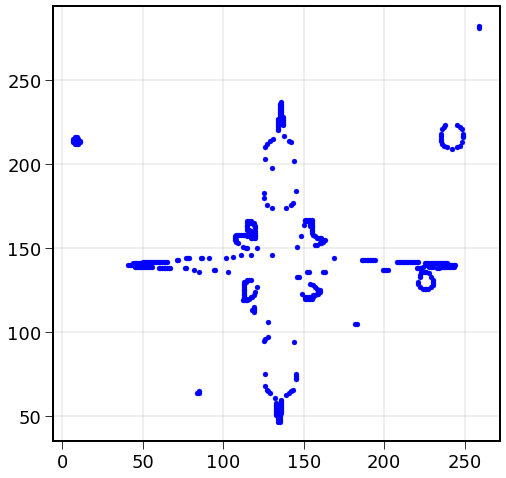

In [411]:
plt.plot(X,Y,"b.")
plt.grid()

## calculate hough data

- array number of points x nb of angles

In [412]:
NBRHOBIN=int(aigrettes.shape[0]/2)
RHOMIN=-aigrettes.shape[0]
RHOMAX=aigrettes.shape[0]

### Bins functions

In [413]:
def getbin(x):
    """
    
    getbin(x):
     from a vector of rhos from, give the corresponding rhos - bin index and return the count number
    
    """
    fraction = (x/RHOMAX+1)*NBRHOBIN/2 
    ibins = fraction.astype(int)  
    ibins = np.where(np.logical_and(ibins>=0,ibins<NBRHOBIN),ibins,-1)
    
    uniquebins,countbins= np.unique(ibins,return_counts=True)
    
    badindexes=np.where(uniquebins==-1)
    keepbins=np.delete(uniquebins,badindexes)
    keepcounts = np.delete(countbins,badindexes)
    
    return keepbins,keepcounts

In [414]:
def getrho(ibin):
    return (ibin-NBRHOBIN/2.)/(NBRHOBIN/2.)*RHOMAX

### Arrays for storing

In [415]:
hough_data=np.zeros((NBPoints,NBAng))
hough_accumulator = np.zeros((NBRHOBIN,NBAng))

## Compute r (or rho) for each point and angle

In [416]:
# fill hough data givin the r for each point
# loop on angles to fill hough_data
for iang in np.arange(NBAng):
    costh=np.cos(theta_rad[iang])
    sinth=np.sin(theta_rad[iang])
    # compute rho for each point (x,y)
    rho = X*costh+Y*sinth 
    hough_data[:,iang] = rho
    
    # fill the accumulator :
    # search in which rho-bin the points should be attributed 
    thebins,thecounts=getbin(rho)
    
    for ibin in np.arange(len(thebins)):
        hough_accumulator[thebins[ibin],iang] = hough_accumulator[thebins[ibin],iang] + thecounts[ibin]


## Plot Hough line space

In [417]:
NBRHOBIN=int(aigrettes.shape[0]/2)
RHOMIN=-aigrettes.shape[0]
RHOMAX=aigrettes.shape[0]

### Plot Hough Line space 2D

In [418]:
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NBPoints)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBPoints), alpha=1)

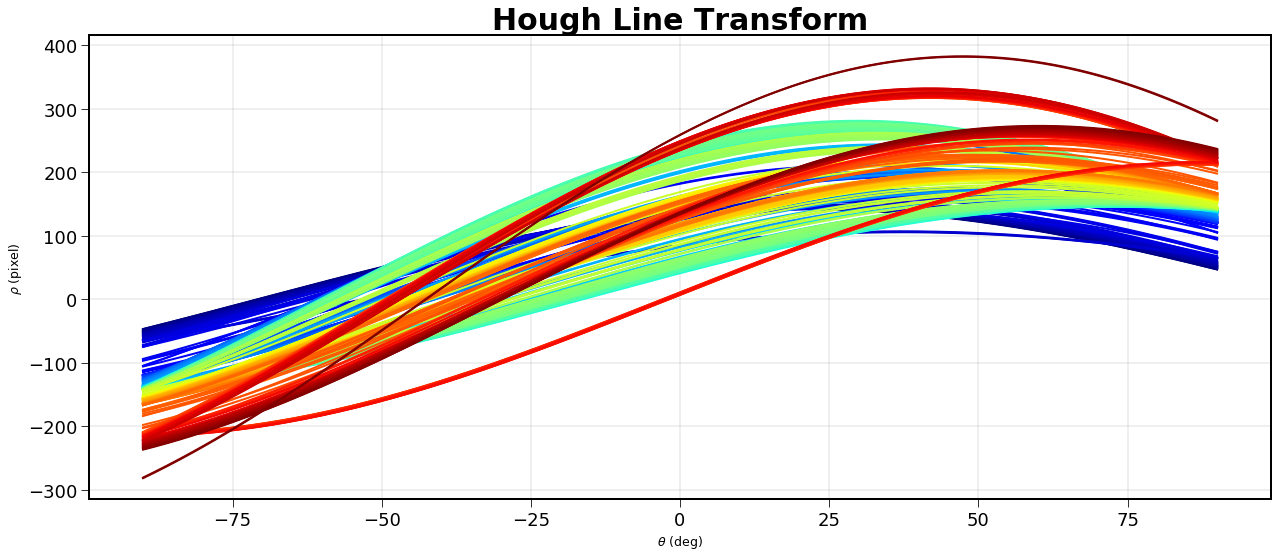

In [419]:
# loop on angles
plt.figure(figsize=(18,8))

for ipoint in np.arange(NBPoints):    
    plt.plot(theta_deg,hough_data[ipoint,:],"-",color=all_colors[ipoint])
    
plt.grid()
plt.title("Hough Line Transform",fontsize=30)
plt.xlabel("$\\theta$ (deg)")
plt.ylabel("$\\rho$ (pixel)")
figname=string_date+"_houghline_1.png"
plt.tight_layout()
plt.savefig(figname)

### Show Hough line histogram

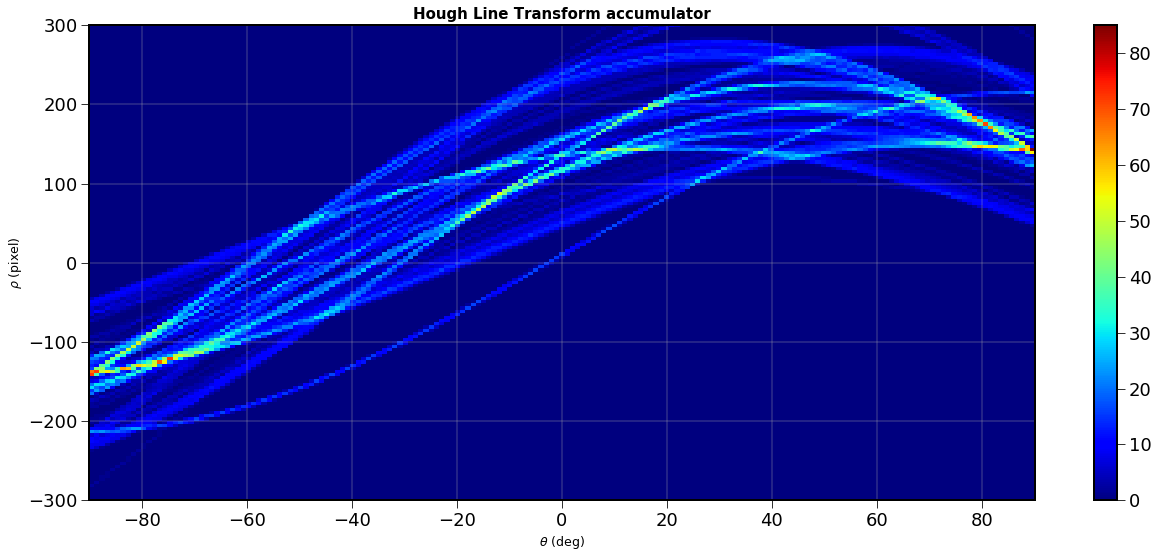

In [420]:
extent=(theta_deg.min(), theta_deg.max(),RHOMIN,RHOMAX)
plt.figure(figsize=(18,8))
im=plt.imshow(hough_accumulator,origin="lower",extent=extent,cmap=plt.cm.jet,aspect="auto")
plt.grid()
plt.title("Hough Line Transform accumulator")
plt.xlabel("$\\theta$ (deg)")
plt.ylabel("$\\rho$ (pixel)")
plt.colorbar(im)
figname=string_date+"_houghline_2.png"
plt.tight_layout()
plt.savefig(figname)

### Statistic in Hough line space

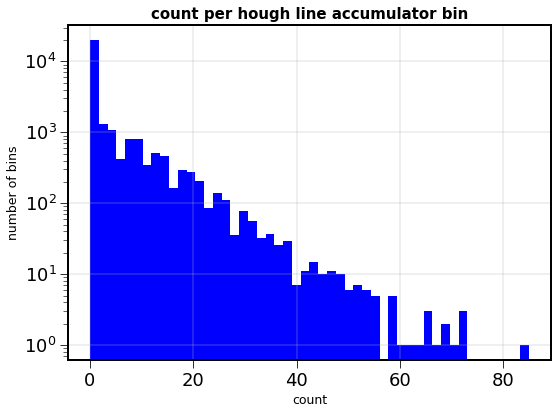

In [421]:
plt.figure(figsize=(8,6))
hist_data=plt.hist(hough_accumulator.flatten(),bins=50,facecolor="b")
plt.yscale("log")
plt.title("count per hough line accumulator bin")
plt.grid()
plt.xlabel("count")
plt.ylabel("number of bins")
figname=string_date+"_houghline_3.png"
plt.tight_layout()
plt.savefig(figname)

In [422]:
count,bin_val=np.log10(hist_data[0]), hist_data[1]

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


### Selected accumulation

In [423]:
ipeak_y,ipeak_x=np.where(hough_accumulator>430)

In [424]:
YY=getrho(ipeak_y)
XX=theta_deg[ipeak_x]

In [425]:
selected_rhos=YY
selected_thetas=XX

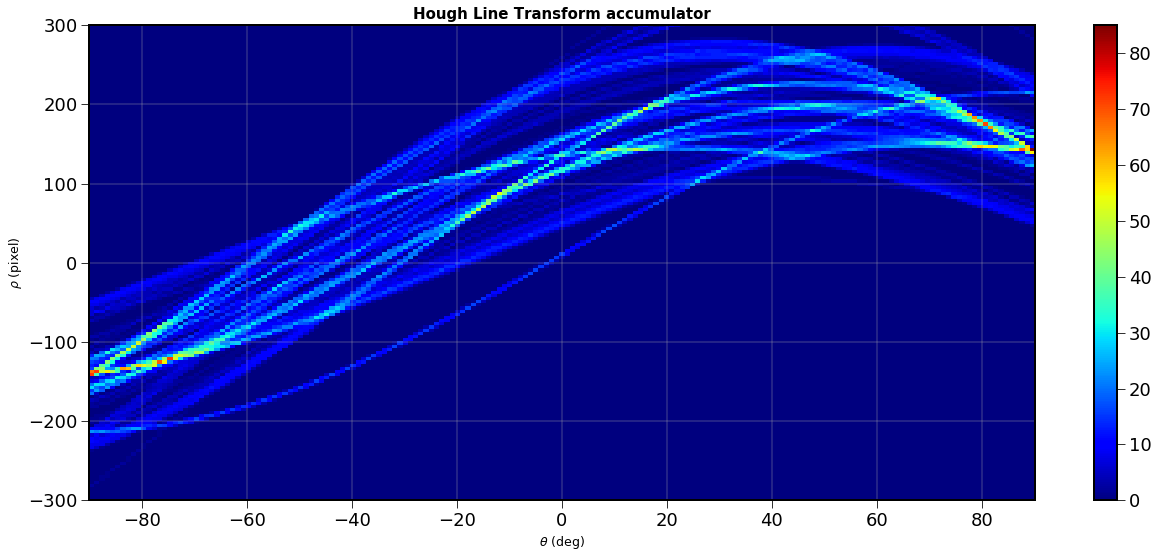

In [426]:
extent=(theta_deg.min(), theta_deg.max(),RHOMIN,RHOMAX)
plt.figure(figsize=(18,8))
im=plt.imshow(hough_accumulator,origin="lower",extent=extent,cmap=plt.cm.jet,aspect="auto")
plt.scatter(XX,YY, c='r', marker='+',s=50**2)
plt.grid()
plt.title("Hough Line Transform accumulator")
plt.xlabel("$\\theta$ (deg)")
plt.ylabel("$\\rho$ (pixel)")
plt.colorbar(im)
figname=string_date+"_houghline_4.png"
plt.tight_layout()
plt.savefig(figname)

### Filtered Hough line accumulator

In [427]:
hough_accumulator_filt=gaussian(hough_accumulator,sigma=[1,1])

In [428]:
hough_accumulator_filt.shape

(150, 181)

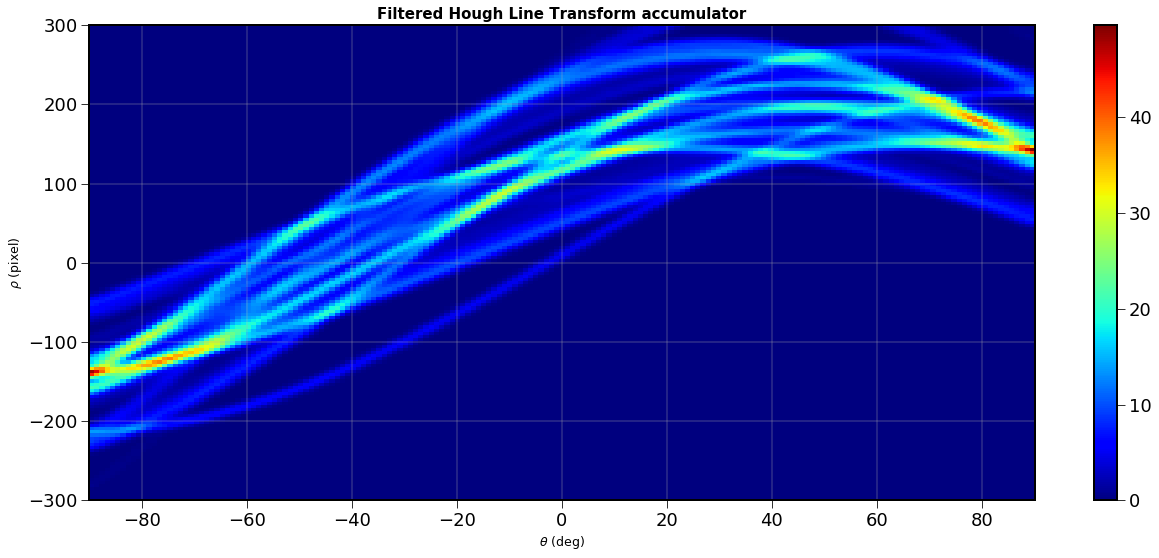

In [429]:
extent=(theta_deg.min(), theta_deg.max(),RHOMIN,RHOMAX)
plt.figure(figsize=(18,8))
im=plt.imshow(hough_accumulator_filt,origin="lower",extent=extent,cmap=plt.cm.jet,aspect="auto")
plt.grid()
plt.title("Filtered Hough Line Transform accumulator")
plt.xlabel("$\\theta$ (deg)")
plt.ylabel("$\\rho$ (pixel)")
plt.colorbar(im)
figname=string_date+"_houghline_5.png"
plt.tight_layout()
plt.savefig(figname)

### Statistic for filttered accumulator

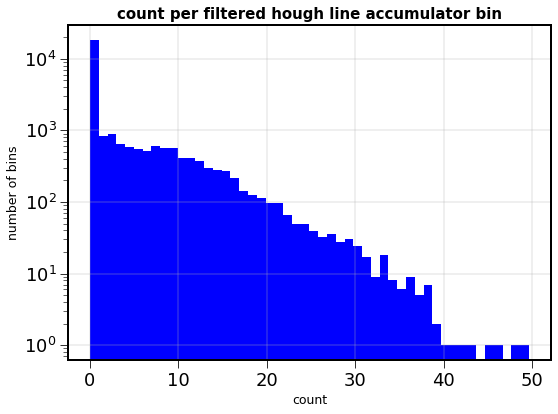

In [430]:
plt.figure(figsize=(8,6))
plt.hist(hough_accumulator_filt.flatten(),bins=50,facecolor="b")
plt.yscale("log")
plt.title("count per filtered hough line accumulator bin")
plt.grid()
plt.xlabel("count")
plt.ylabel("number of bins")
figname=string_date+"_houghline_6.png"
plt.tight_layout()
plt.savefig(figname)

### Plot selected points in filtered accumulator

In [431]:
ipeak_y,ipeak_x=np.where(hough_accumulator_filt>=30)

In [432]:
YY=getrho(ipeak_y)
XX=theta_deg[ipeak_x]

In [433]:
len(XX)

108

In [434]:
selected_rhos=YY
selected_thetas=XX
selected_ipeak_rhos = ipeak_y
selected_ipeak_angles = ipeak_x

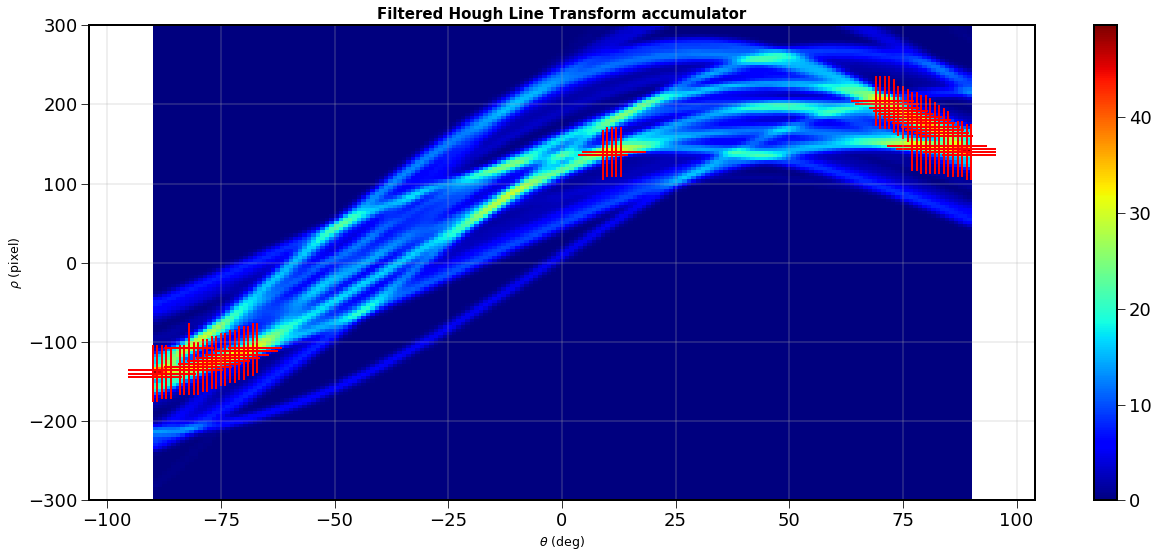

In [435]:
extent=(theta_deg.min(), theta_deg.max(),RHOMIN,RHOMAX)
plt.figure(figsize=(18,8))
im=plt.imshow(hough_accumulator_filt,origin="lower",extent=extent,cmap=plt.cm.jet,aspect="auto")
plt.scatter(XX,YY, c='r', marker='+',s=50**2)
plt.grid()
plt.title("Filtered Hough Line Transform accumulator")
plt.xlabel("$\\theta$ (deg)")
plt.ylabel("$\\rho$ (pixel)")
plt.colorbar(im)
figname=string_date+"_houghline_7.png"
plt.tight_layout()
plt.savefig(figname)

# Draw aigrettes

In [436]:
len(selected_rhos)

108

In [437]:
selected_rhos

array([-144., -144., -140., -140., -140., -140., -140., -136., -136.,
       -136., -136., -136., -136., -136., -136., -136., -132., -132.,
       -132., -132., -132., -128., -128., -128., -128., -124., -124.,
       -124., -124., -120., -120., -120., -120., -116., -116., -116.,
       -116., -112., -112., -112., -112., -108., -108., -108.,  136.,
        136.,  136.,  140.,  140.,  140.,  140.,  140.,  140.,  140.,
        140.,  140.,  140.,  144.,  144.,  144.,  144.,  144.,  144.,
        144.,  144.,  144.,  144.,  144.,  144.,  148.,  148.,  148.,
        148.,  148.,  160.,  160.,  164.,  164.,  168.,  168.,  168.,
        172.,  172.,  172.,  176.,  176.,  176.,  176.,  180.,  180.,
        180.,  180.,  184.,  184.,  184.,  188.,  188.,  192.,  192.,
        196.,  200.,  200.,  200.,  200.,  204.,  204.,  204.,  204.])

In [438]:
selected_thetas

array([-90, -89, -90, -89, -88, -87, -86, -90, -89, -88, -87, -84, -83,
       -82, -81, -80, -82, -81, -80, -79, -78, -79, -78, -77, -76, -77,
       -76, -75, -74, -75, -74, -73, -72, -73, -72, -71, -70, -71, -70,
       -69, -68, -82, -68, -67,   9,  89,  90,  10,  11,  12,  13,  85,
        86,  87,  88,  89,  90,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  77,  78,  79,  87,  88,  84,  85,  83,  84,
        81,  82,  83,  80,  81,  82,  78,  79,  80,  81,  77,  78,  79,
        80,  76,  77,  78,  75,  76,  74,  75,  73,  70,  71,  72,  73,
        69,  70,  71,  72])

In [439]:
NSEG=len(selected_rhos)

In [440]:
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSEG)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEG), alpha=1)

Text(0.5, 0.8, 'Fit of aigrettes from lambda_minus clipped')

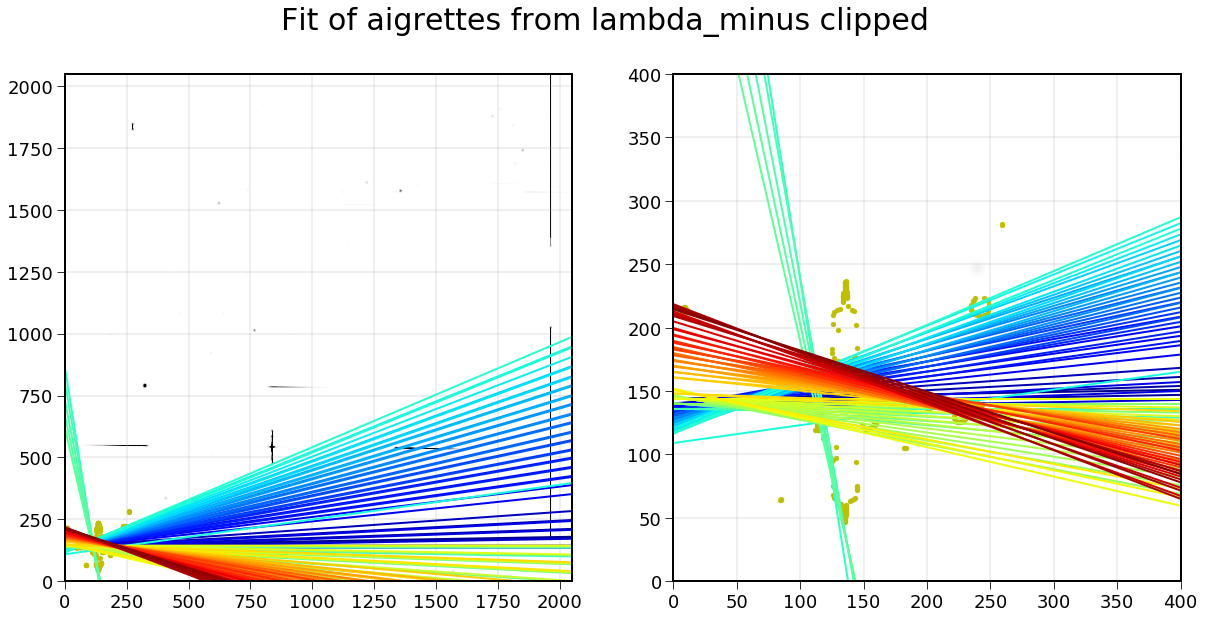

In [441]:
XMIN1=0
XMAX1=lambda_minus.shape[1]
YMIN1=0
YMAX1=lambda_minus.shape[0]

XMIN2=0
XMAX2=400
YMIN2=0
YMAX2=400

# figure 1
fig=plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
img=plt.imshow(lambda_minus,origin="lower",cmap="gray")

plt.plot(X,Y,".",color='y')
#plt.grid()

X1=np.arange(XMIN1,XMAX1)
for index in np.arange(NSEG):
    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    XH=rho*np.cos(theta)
    YH=rho*np.sin(theta)
    slope=-np.tan(np.pi/2-theta)
    
    Y1=-np.tan(np.pi/2-theta)*X1+rho/np.sin(theta)
    #Y1=slope*(X1-XH)+YH
    plt.plot(X1,Y1,'-',color=all_colors[index])
    #plt.scatter([XH],[YH], c=all_colors[index], marker='+',s=50**2)

plt.grid()
plt.xlim(XMIN1,XMAX1)
plt.ylim(YMIN1,YMAX1)


# figure 2
plt.subplot(1,2,2)
img=plt.imshow(lambda_minus,origin="lower",cmap="gray")

plt.plot(X,Y,".",color='y')

X2=np.arange(XMIN2,XMAX2)
for index in np.arange(NSEG):
    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    XH=rho*np.cos(theta)
    YH=rho*np.sin(theta)
    slope=-np.tan(np.pi/2-theta)
    
    Y2=-np.tan(np.pi/2-theta)*X2+rho/np.sin(theta)
    #Y2=slope*(X2-XH)+YH
    plt.plot(X2,Y2,'-',color=all_colors[index])

plt.xlim(XMIN2,XMAX2)
plt.ylim(YMIN2,YMAX2)
plt.grid()
title="Fit of aigrettes from "+ main_title
plt.suptitle(title,fontsize=30,y=.8)



In [442]:
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSEG)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEG), alpha=1)

Text(0.5, 0.99, 'Zoom on Fit of aigrettes from lambda_minus clipped')

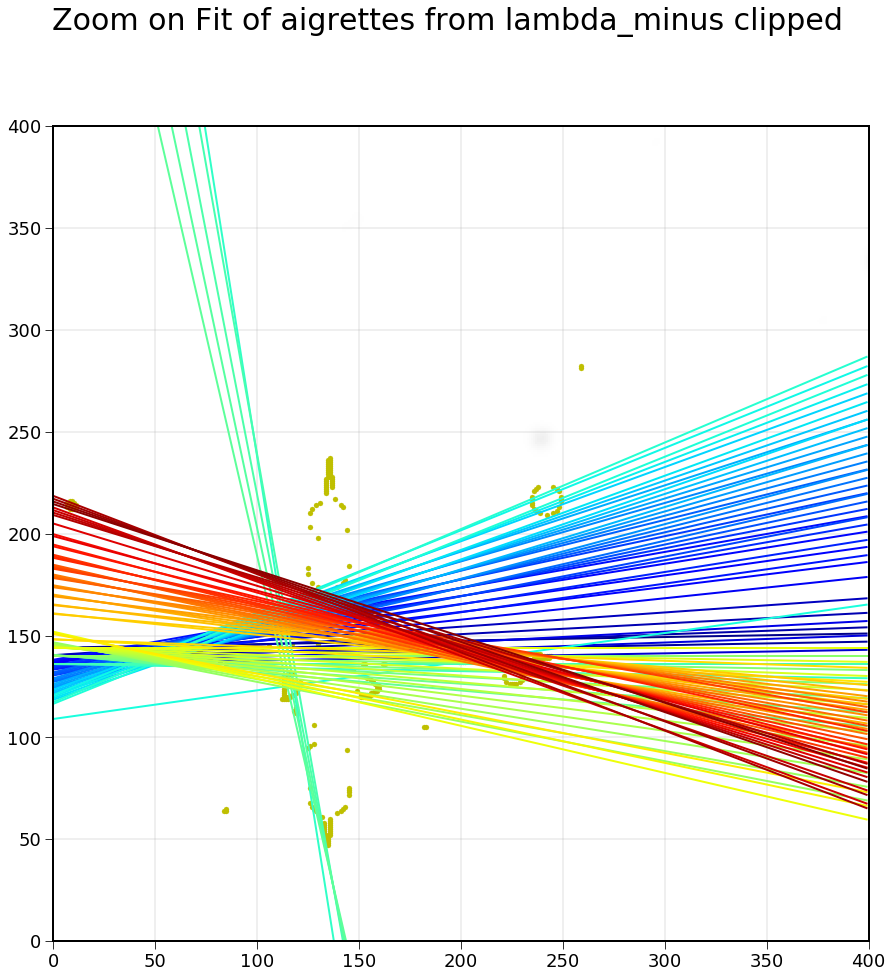

In [443]:
# figure 3

XMIN3=0
XMAX3=400
YMIN3=0
YMAX3=400


plt.figure(figsize=(15,15))

img=plt.imshow(lambda_minus,origin="lower",cmap="gray")

plt.plot(X,Y,".",color='y')

X3=np.arange(XMIN3,XMAX3)
for index in np.arange(NSEG):
    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    XH=rho*np.cos(theta)
    YH=rho*np.sin(theta)
    slope=-np.tan(np.pi/2.0-theta)
    
    Y3=-np.tan(np.pi/2-theta)*X3+rho/np.sin(theta)
    #Y3=slope*(X3-XH)+YH
    plt.plot(X3,Y3,'-',color=all_colors[index])

plt.xlim(XMIN3,XMAX3)
plt.ylim(YMIN3,YMAX3)
plt.grid()
title="Zoom on Fit of aigrettes from "+ main_title
plt.suptitle(title,fontsize=30,y=.99)


## find original points of aigrettes 

In [444]:
selected_ipeak_rhos

array([ 39,  39,  40,  40,  40,  40,  40,  41,  41,  41,  41,  41,  41,
        41,  41,  41,  42,  42,  42,  42,  42,  43,  43,  43,  43,  44,
        44,  44,  44,  45,  45,  45,  45,  46,  46,  46,  46,  47,  47,
        47,  47,  48,  48,  48, 109, 109, 109, 110, 110, 110, 110, 110,
       110, 110, 110, 110, 110, 111, 111, 111, 111, 111, 111, 111, 111,
       111, 111, 111, 111, 112, 112, 112, 112, 112, 115, 115, 116, 116,
       117, 117, 117, 118, 118, 118, 119, 119, 119, 119, 120, 120, 120,
       120, 121, 121, 121, 122, 122, 123, 123, 124, 125, 125, 125, 125,
       126, 126, 126, 126])

In [445]:
# container of point indexes for each segments
all_segments_indexes = []

# loop on the selected segments
for index in np.arange(NSEG):
    
    # angle and rho of the selected segment     
    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    costh=np.cos(theta)
    sinth=np.sin(theta)
    
    # find the bin indexes in hough space
    ipeak_x_sel=selected_ipeak_angles[index]
    ipeak_y_sel=selected_ipeak_rhos[index]
    
    # container of points for that segments
    points_indexes_segments = []
    
   
    # compute rho for each point (x,y)
    rho = X*costh+Y*sinth 
    
    fraction = (rho/RHOMAX+1)*NBRHOBIN/2 
    ibins = fraction.astype(int)  
    ibins = np.where(np.logical_and(ibins>=0,ibins<NBRHOBIN),ibins,-1)
    
    # find the points identifiers 
    selected_points = np.where(ibins == ipeak_y_sel)[0]
      
    all_segments_indexes.append(selected_points)
   

In [446]:
len(all_segments_indexes) 

108

In [447]:
lambda_plus=np.copy(image.img_cube[parameters.IndexImg.lambda_plus_clip])
original=np.copy(image.img_cube[parameters.IndexImg.img_clip]) 

In [448]:
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSEG)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEG), alpha=1)

Text(0.5, 0.99, 'Zoom on aigrettes points from lambda_minus clipped')

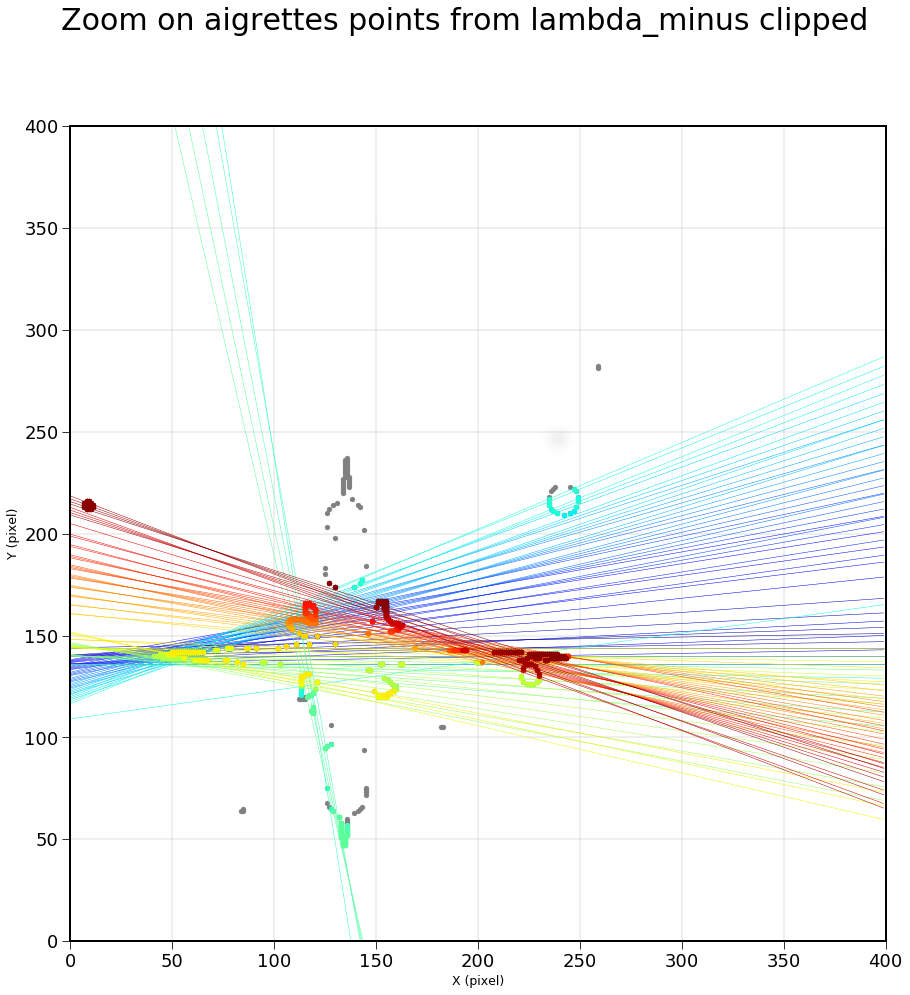

In [449]:
# figure 4

XMIN4=0
XMAX4=400
YMIN4=0
YMAX4=400

X4=np.arange(XMIN4,XMAX4)

plt.figure(figsize=(15,15))

img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
#img=plt.imshow(lambda_plus,origin="lower",cmap="gray")
plt.plot(X,Y,".",color='gray')

# loop on the selected segments
for index in np.arange(NSEG):

    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    
    # plot points
    list_of_points_indexes = all_segments_indexes[index]  
    plt.plot(X[list_of_points_indexes],Y[list_of_points_indexes],".",color=all_colors[index])

    
    # plot lines
    Y4=-np.tan(np.pi/2-theta)*X4+rho/np.sin(theta)
  
    plt.plot(X4,Y4,'-',color=all_colors[index],lw=0.5)
plt.xlabel("X (pixel)")    
plt.ylabel("Y (pixel)")    
plt.xlim(XMIN4,XMAX4)
plt.ylim(YMIN4,YMAX4)
plt.grid()
title="Zoom on aigrettes points from "+ main_title
plt.suptitle(title,fontsize=30,y=.99)
  

In [450]:
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSEG)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEG), alpha=1)

Text(0.5, 0.99, 'Aigrettes points from lambda_minus clipped $\\lambda$+ at center')

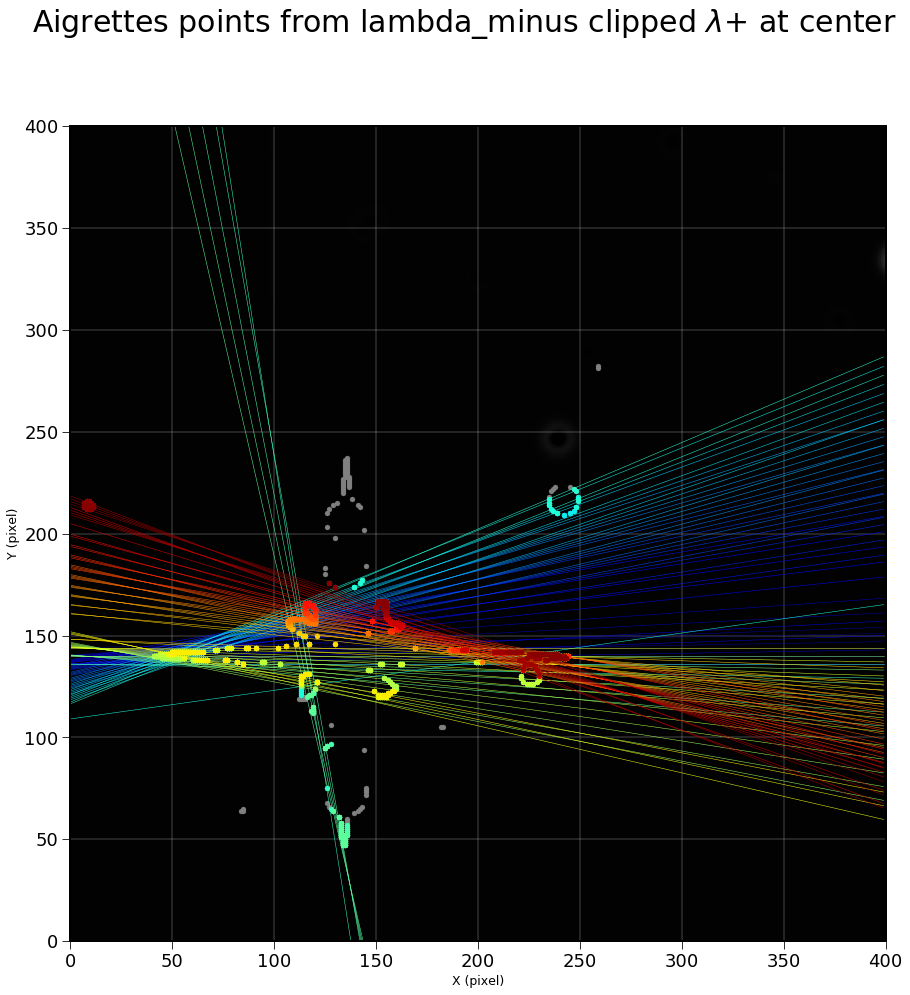

In [451]:
# figure 4

XMIN4=0
XMAX4=400
YMIN4=0
YMAX4=400

X4=np.arange(XMIN4,XMAX4)

plt.figure(figsize=(15,15))

#img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
img=plt.imshow(lambda_plus,origin="lower",cmap="gray")
plt.plot(X,Y,".",color='gray')

# loop on the selected segments
for index in np.arange(NSEG):

    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    
    # plot points
    list_of_points_indexes = all_segments_indexes[index]  
    plt.plot(X[list_of_points_indexes],Y[list_of_points_indexes],".",color=all_colors[index])

    
    # plot lines
    Y4=-np.tan(np.pi/2-theta)*X4+rho/np.sin(theta)
  
    plt.plot(X4,Y4,'-',color=all_colors[index],lw=0.5)
plt.xlabel("X (pixel)")    
plt.ylabel("Y (pixel)")    
plt.xlim(XMIN4,XMAX4)
plt.ylim(YMIN4,YMAX4)
plt.grid()
title="Aigrettes points from "+ main_title + " $\\lambda$+ at center"
plt.suptitle(title,fontsize=30,y=.99)
  

In [452]:
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSEG)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEG), alpha=1)

Text(0.5, 0.99, 'Aigrettes points from lambda_minus clipped original image bg')

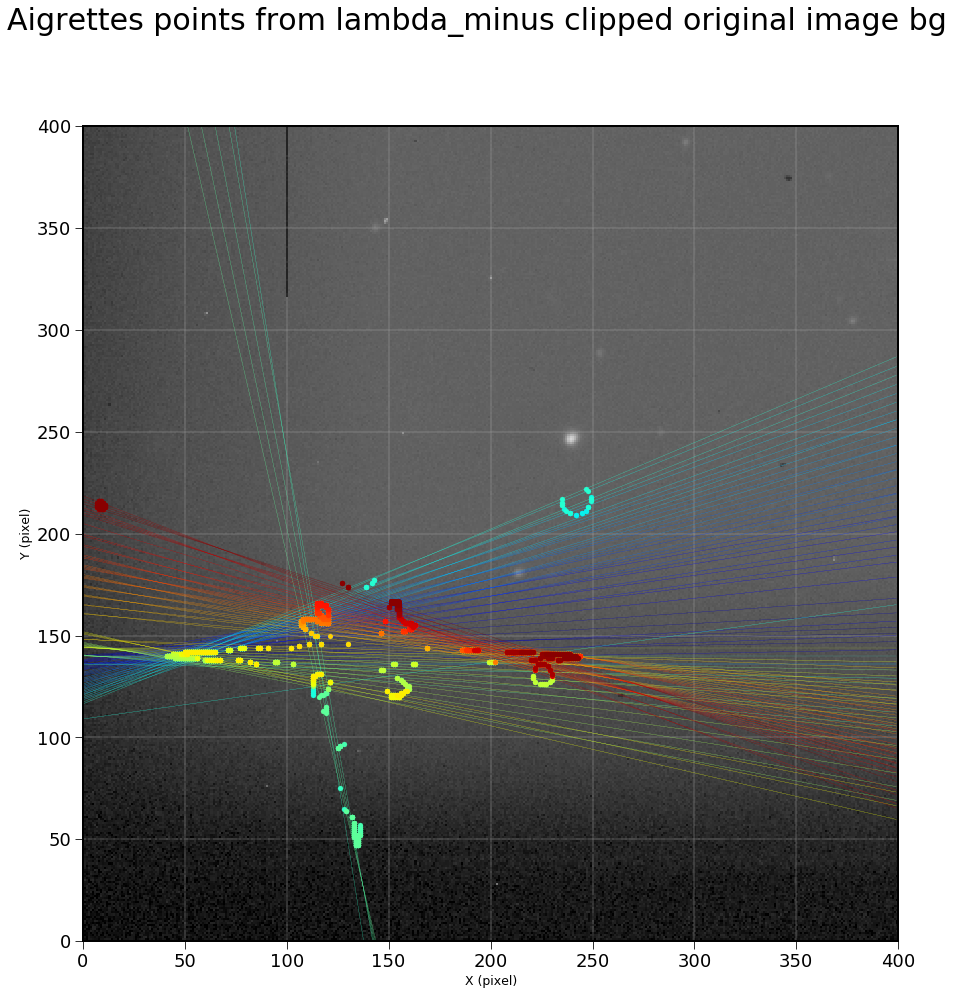

In [453]:
# figure 4

XMIN4=0
XMAX4=400
YMIN4=0
YMAX4=400

X4=np.arange(XMIN4,XMAX4)

plt.figure(figsize=(15,15))

#img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
vmin=original.flatten().min()
vmax=original.flatten().max()
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
img=plt.imshow(original,origin="lower",norm=norm,cmap="gray")
#plt.plot(X,Y,".",color='gray')

# loop on the selected segments
for index in np.arange(NSEG):

    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    
    # plot points
    list_of_points_indexes = all_segments_indexes[index]  
    plt.plot(X[list_of_points_indexes],Y[list_of_points_indexes],".",color=all_colors[index],lw=0.25)

    
    # plot lines
    Y4=-np.tan(np.pi/2-theta)*X4+rho/np.sin(theta)
  
    plt.plot(X4,Y4,'-',color=all_colors[index],lw=0.25)
plt.xlabel("X (pixel)")    
plt.ylabel("Y (pixel)")    
plt.xlim(XMIN4,XMAX4)
plt.ylim(YMIN4,YMAX4)
plt.grid()
title="Aigrettes points from "+ main_title + " original image bg"
plt.suptitle(title,fontsize=30,y=.99)
  

# Fit  straight lines for each segment from its points

## Extract weight

In [454]:
W = np.zeros(NBPoints)
for ipoint in list_of_points_indexes:
    thex=X[ipoint]
    they=Y[ipoint]
    #W[ipoint] = original[they,thex]
    W[ipoint] = -lambda_minus[they,thex]

In [455]:
W.max()

0.23506474820731987

Text(0.5, 1.0, 'weight of aigrette pixels in original image ')

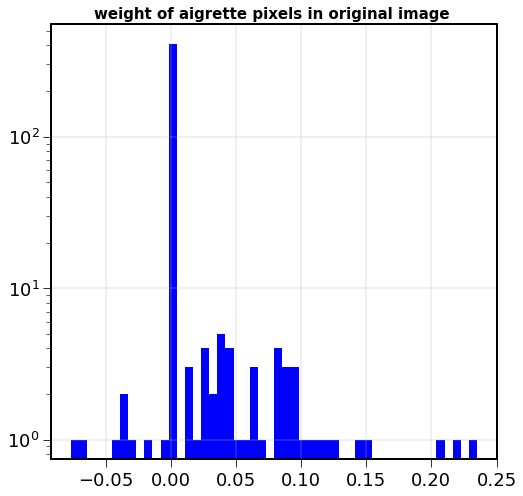

In [456]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.hist(W,bins=50,range=(0,500),facecolor="b")
ax.hist(W,bins=50,facecolor="b")
ax.set_yscale('log',basey=10)
ax.grid()
ax.set_title("weight of aigrette pixels in original image ")

In [457]:
jet = plt.get_cmap('gray')
plasma=plt.cm.plasma
cNorm = mpl.colors.Normalize(vmin=0, vmax=NBPoints)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plasma)
all_colors = scalarMap.to_rgba(np.arange(NBPoints), alpha=1)

(0, 500)

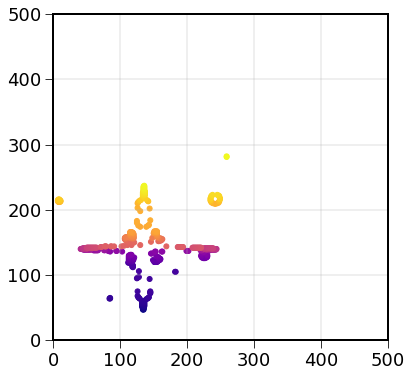

In [458]:
plt.figure(figsize=(6,6))
plt.scatter(X,Y,c=all_colors,marker=".")
plt.grid()
plt.xlim(0,500)
plt.ylim(0,500)

## Orthogonal distance regression : fit a straight line

https://docs.scipy.org/doc/scipy/reference/odr.html#id1


In [459]:
index=0 
list_of_points_indexes = all_segments_indexes[index]  
X_inseg=X[list_of_points_indexes].astype('float')
Y_inseg=Y[list_of_points_indexes].astype('float')
SX_inseg=np.ones(len(X_inseg))
SY_inseg=np.ones(len(X_inseg))

In [460]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

In [461]:
linear = odr.Model(f)

In [462]:
data = odr.Data(X_inseg, Y_inseg, wd=1./np.power(SX_inseg,2), we=1./np.power(SX_inseg,2))

In [463]:
myodr = odr.ODR(data, linear, beta0=[1., 2.])

In [464]:
myoutput = myodr.run()

In [465]:
myoutput.pprint()

Beta: [-2.40546111e-03  1.42403178e+02]
Beta Std Error: [0.0014408  0.23644263]
Beta Covariance: [[ 2.29711435e-06 -3.31964752e-04]
 [-3.31964752e-04  6.18624612e-02]]
Residual Variance: 0.9037001559123659
Inverse Condition #: 0.0028801608901079336
Reason(s) for Halting:
  Sum of squares convergence


In [466]:
myoutput.beta

array([-2.40546111e-03,  1.42403178e+02])

In [467]:
myoutput.sd_beta

array([0.0014408 , 0.23644263])

In [468]:
myoutput.cov_beta

array([[ 2.29711435e-06, -3.31964752e-04],
       [-3.31964752e-04,  6.18624612e-02]])

In [469]:
#myoutput?

In [470]:
parameters = []
Npts = []

for index in np.arange(NSEG):
       
    # extract points for each segments
    list_of_points_indexes = all_segments_indexes[index]  
    Ninseg=len(list_of_points_indexes)
    #print(" -------------------   segment ",index," Nbpoint = ",Ninseg," ----------------------------------")
    
    X_inseg=X[list_of_points_indexes].astype('float')
    Y_inseg=Y[list_of_points_indexes].astype('float')
    SX_inseg=np.ones(len(X_inseg))
    SY_inseg=np.ones(len(X_inseg))
    
    # do the orthogonal fit
    data = odr.Data(X_inseg, Y_inseg, wd=1./np.power(SX_inseg,2), we=1./np.power(SX_inseg,2))
    myodr = odr.ODR(data, linear, beta0=[1., 2.])
    myoutput = myodr.run()
    #myoutput.pprint()
    parameters.append(myoutput.beta)
    Npts.append(Ninseg)

In [471]:
parameters = np.array(parameters)
Npts = np.array(Npts)

In [472]:
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSEG)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEG), alpha=1)

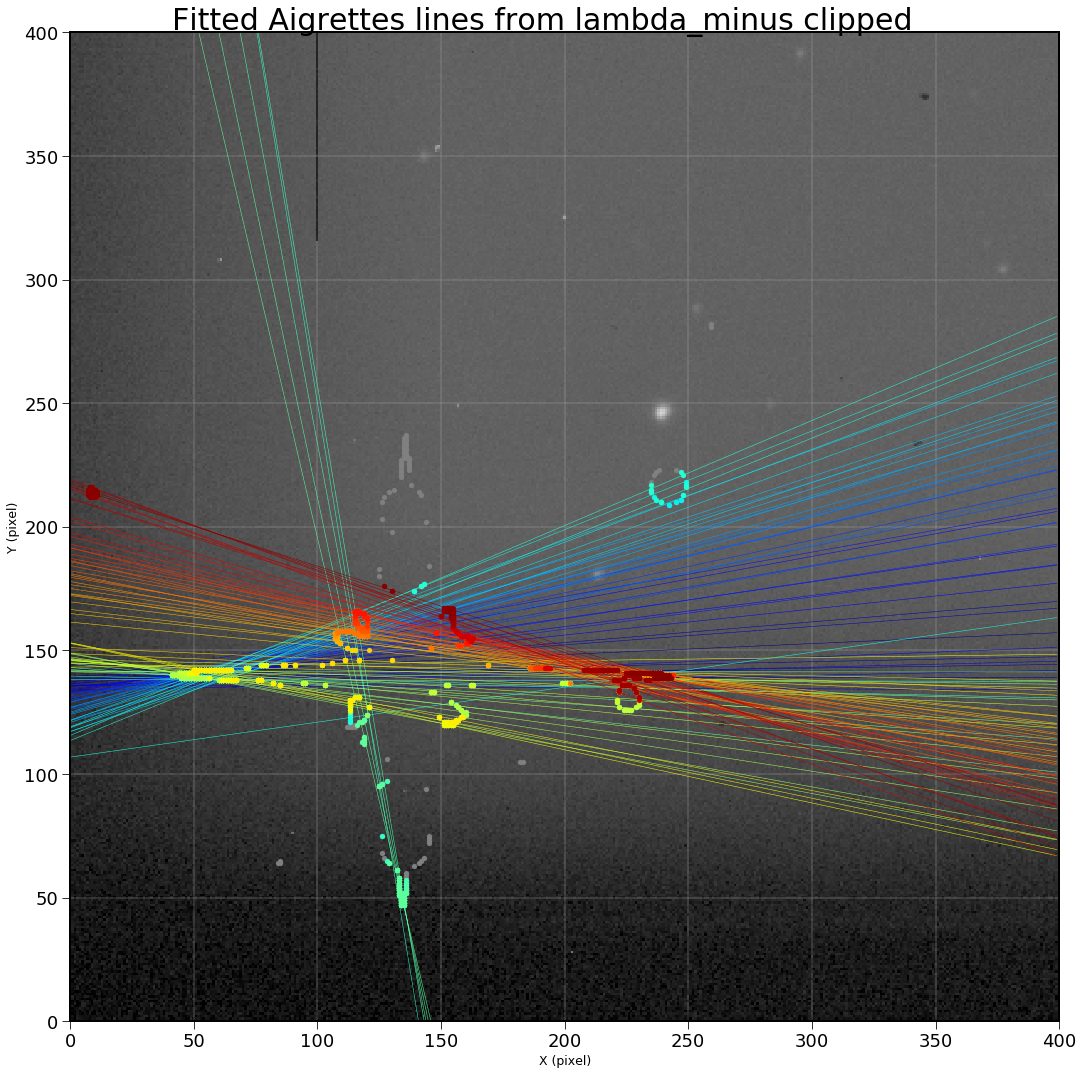

In [473]:
# figure 4

XMIN4=0
XMAX4=400
YMIN4=0
YMAX4=400

X4=np.arange(XMIN4,XMAX4)

plt.figure(figsize=(15,15))

#img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
#img=plt.imshow(lambda_plus,origin="lower",cmap="gray")

vmin=original.flatten().min()
vmax=original.flatten().max()
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
img=plt.imshow(original,origin="lower",norm=norm,cmap="gray")

plt.plot(X,Y,".",color='gray')

# loop on the selected segments
for index in np.arange(NSEG):

    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    
    # plot points
    list_of_points_indexes = all_segments_indexes[index]  
    plt.plot(X[list_of_points_indexes],Y[list_of_points_indexes],".",color=all_colors[index])

    
    # plot lines
    B=parameters[index]
    Y4=f(B, X4)
  
    plt.plot(X4,Y4,'-',color=all_colors[index],lw=0.5)
plt.xlabel("X (pixel)")    
plt.ylabel("Y (pixel)")    
plt.xlim(XMIN4,XMAX4)
plt.ylim(YMIN4,YMAX4)
plt.grid()
title="Fitted Aigrettes lines from "+ main_title
plt.suptitle(title,fontsize=30,y=1)
plt.tight_layout()  
figname=string_date+"_fitaigrettes_1.png"
plt.savefig(figname) 

# Fit central point

In [474]:
# loop on the selected segmentsfor index in np.arange(NSEG):
VX1=np.zeros(NSEG)
VX2=np.zeros(NSEG)
VY1=np.zeros(NSEG)
VY2=np.zeros(NSEG)
for index in np.arange(NSEG):
    
    VX1[index]=X4.min()
    VX2[index]=X4.max()
    
    B=parameters[index]
 
    VY1[index]=f(B, X4.min())
    VY2[index]=f(B, X4.max())
   

In [475]:
X0,Y0,sigX0,sigY0,covXY=fit_centralPoint2(VX1,VX2,VY1,VY2,W=Npts)

In [476]:
X0

117.14564206734491

In [477]:
Y0

150.68917293395202

In [478]:
sigX0

0.0013433405032706616

In [479]:
sigY0

0.00011371682973824542

In [480]:
X4

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

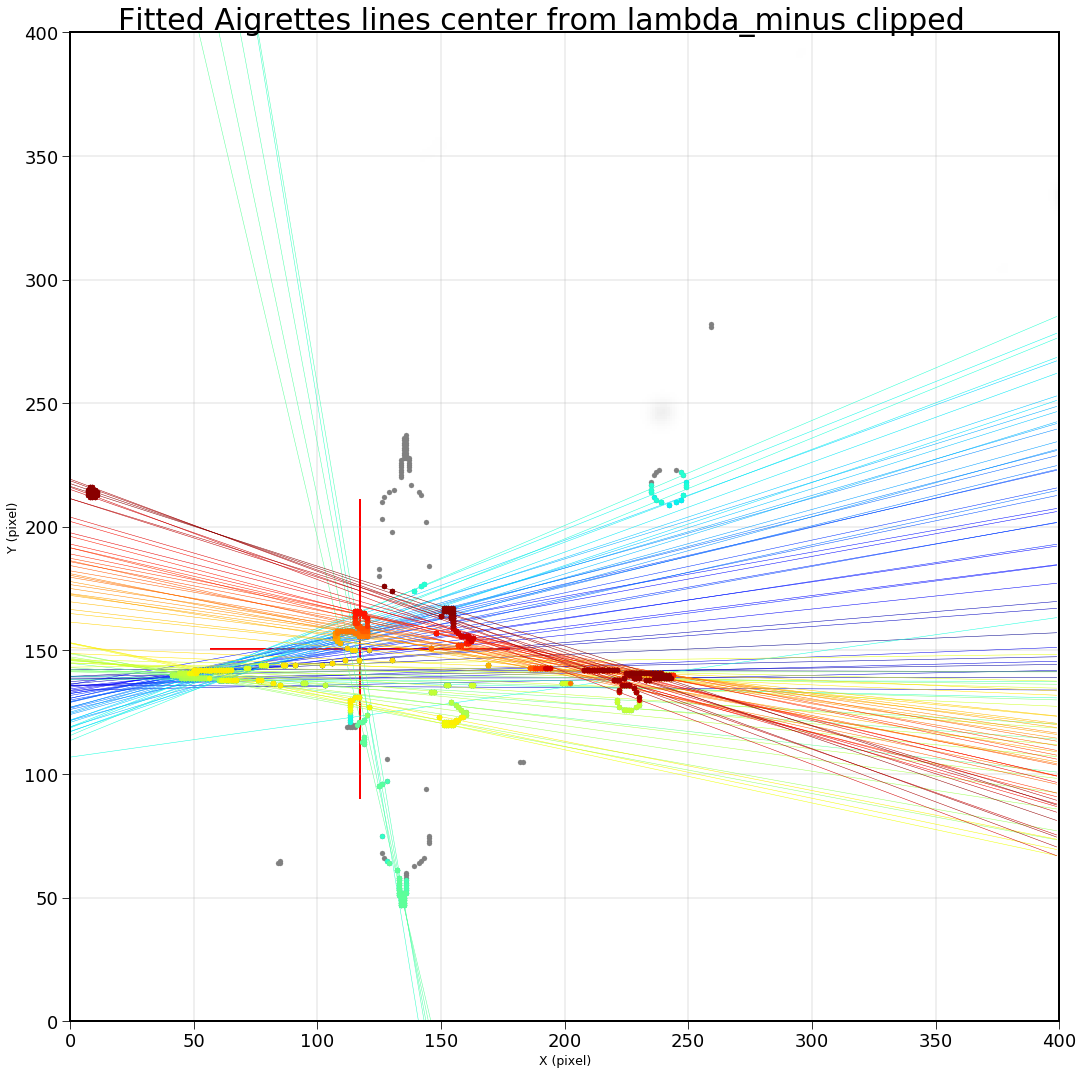

In [481]:
# figure 4

XMIN4=0
XMAX4=400
YMIN4=0
YMAX4=400

X4=np.arange(XMIN4,XMAX4)

plt.figure(figsize=(15,15))

img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
#img=plt.imshow(lambda_plus,origin="lower",cmap="gray")

#vmin=original.flatten().min()
#vmax=original.flatten().max()
#norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
#img=plt.imshow(original,origin="lower",norm=norm,cmap="gray")

plt.plot(X,Y,".",color='gray')

# loop on the selected segments
for index in np.arange(NSEG):

    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    
    # plot points
    list_of_points_indexes = all_segments_indexes[index]  
    plt.plot(X[list_of_points_indexes],Y[list_of_points_indexes],".",color=all_colors[index])

    
    # plot lines
    B=parameters[index]
    Y4=f(B, X4)
  
    plt.plot(X4,Y4,'-',color=all_colors[index],lw=0.5)
    
    
plt.scatter([X0],[Y0],marker="+",s=300**2,c="red",lw=2)

plt.xlabel("X (pixel)")    
plt.ylabel("Y (pixel)")    
plt.xlim(XMIN4,XMAX4)
plt.ylim(YMIN4,YMAX4)
plt.grid()
title="Fitted Aigrettes lines center from "+ main_title
plt.suptitle(title,fontsize=30,y=1)
figname=string_date+"_fitaigrettecenter_1.png"
plt.tight_layout()
plt.savefig(figname)  

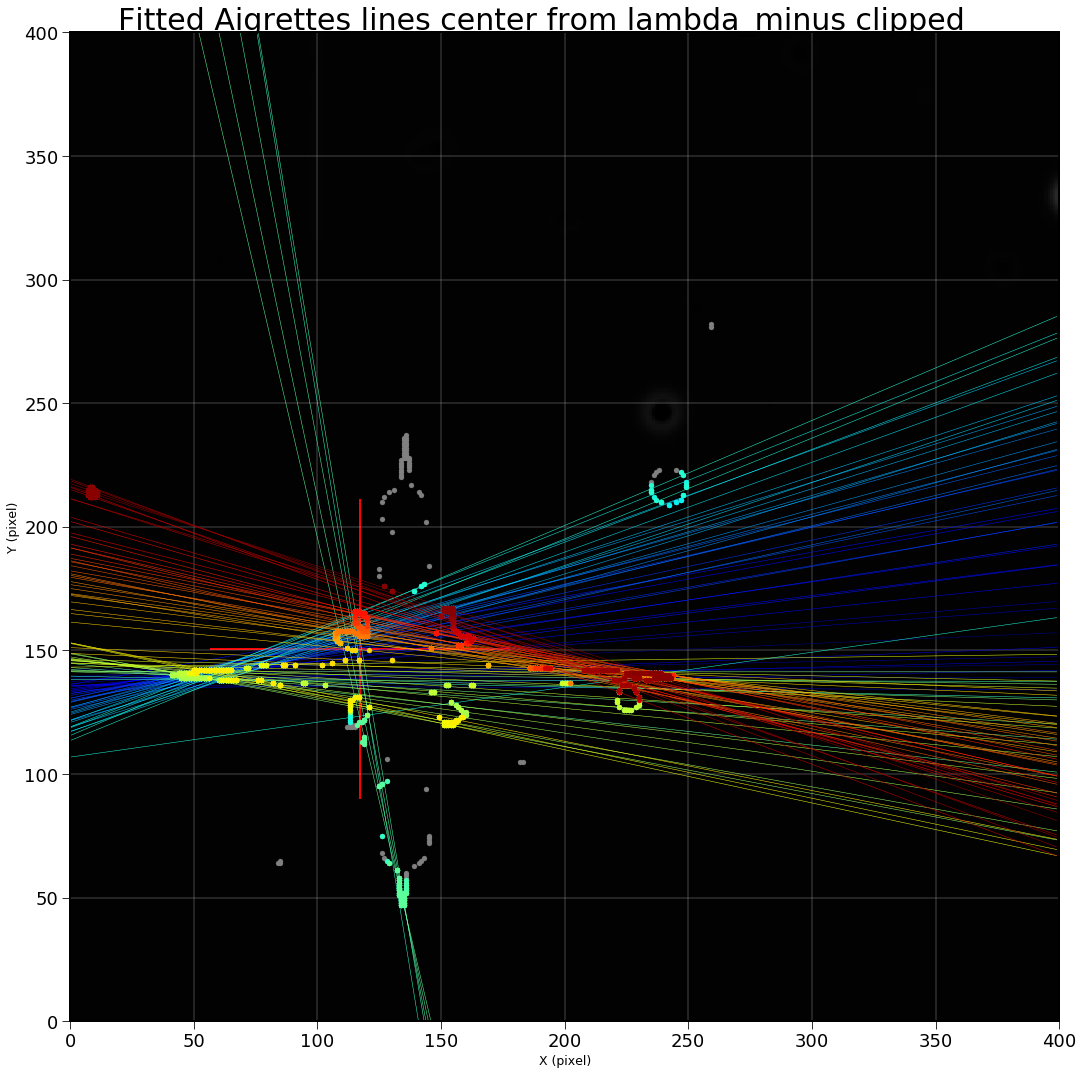

In [482]:
# figure 4

XMIN4=0
XMAX4=400
YMIN4=0
YMAX4=400

X4=np.arange(XMIN4,XMAX4)

plt.figure(figsize=(15,15))

#img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
img=plt.imshow(lambda_plus,origin="lower",cmap="gray")

#vmin=original.flatten().min()
#vmax=original.flatten().max()
#norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
#img=plt.imshow(original,origin="lower",norm=norm,cmap="gray")

plt.plot(X,Y,".",color='gray')

# loop on the selected segments
for index in np.arange(NSEG):

    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    
    # plot points
    list_of_points_indexes = all_segments_indexes[index]  
    plt.plot(X[list_of_points_indexes],Y[list_of_points_indexes],".",color=all_colors[index])

    
    # plot lines
    B=parameters[index]
    Y4=f(B, X4)
  
    plt.plot(X4,Y4,'-',color=all_colors[index],lw=0.5)
    
    
plt.scatter([X0],[Y0],marker="+",s=300**2,c="red",lw=2)

plt.xlabel("X (pixel)")    
plt.ylabel("Y (pixel)")    
plt.xlim(XMIN4,XMAX4)
plt.ylim(YMIN4,YMAX4)
plt.grid()
title="Fitted Aigrettes lines center from "+ main_title
plt.suptitle(title,fontsize=30,y=1)
figname=string_date+"_fitaigrettecenter_2.png"
plt.tight_layout()
plt.savefig(figname)    

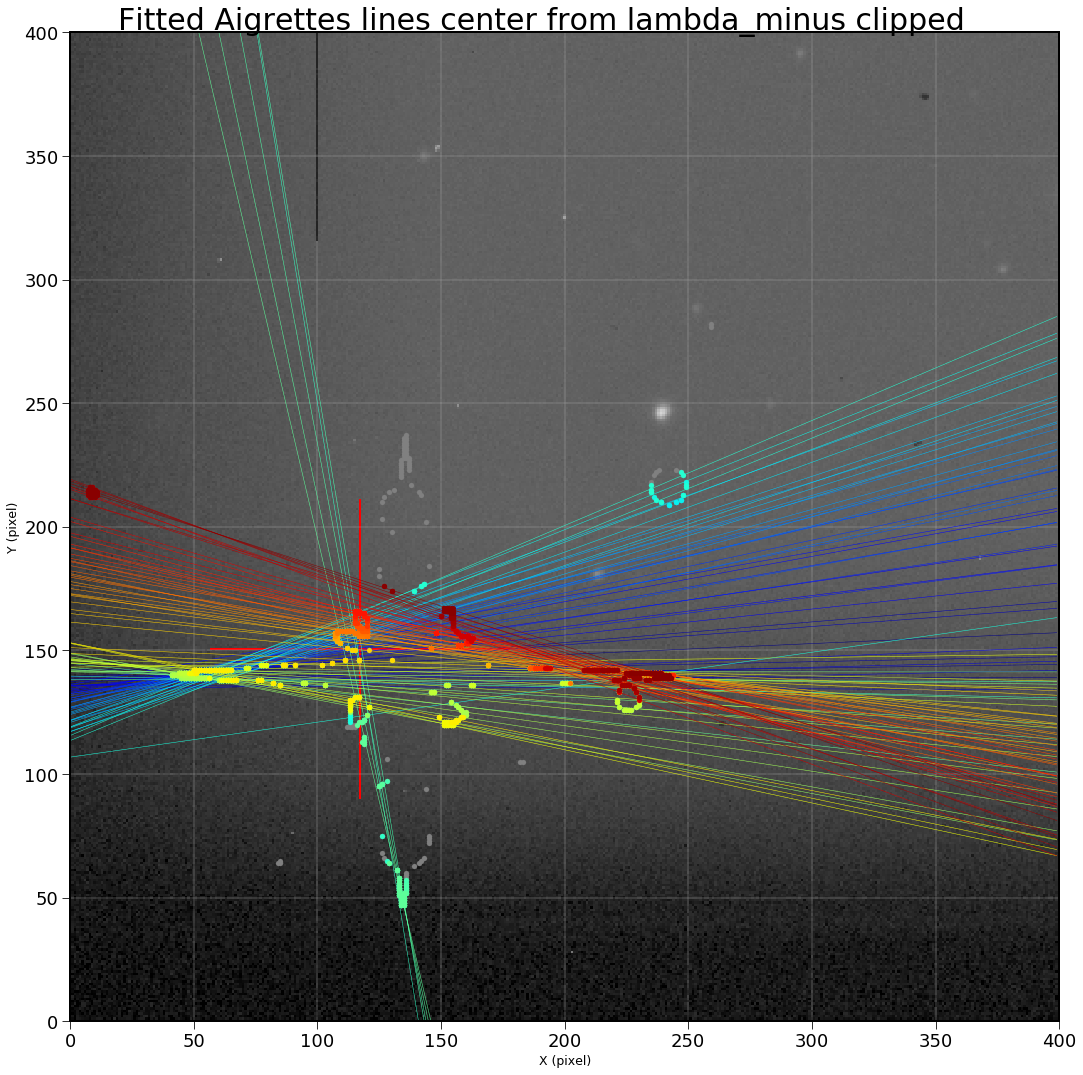

In [483]:
# figure 4

XMIN4=0
XMAX4=400
YMIN4=0
YMAX4=400

X4=np.arange(XMIN4,XMAX4)

plt.figure(figsize=(15,15))

#img=plt.imshow(lambda_minus,origin="lower",cmap="gray")
#img=plt.imshow(lambda_plus,origin="lower",cmap="gray")

vmin=original.flatten().min()
vmax=original.flatten().max()
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LogStretch())
img=plt.imshow(original,origin="lower",norm=norm,cmap="gray")

plt.plot(X,Y,".",color='gray')

# loop on the selected segments
for index in np.arange(NSEG):

    theta=np.radians(selected_thetas[index])
    rho=selected_rhos[index]
    
    
    # plot points
    list_of_points_indexes = all_segments_indexes[index]  
    plt.plot(X[list_of_points_indexes],Y[list_of_points_indexes],".",color=all_colors[index])

    
    # plot lines
    B=parameters[index]
    Y4=f(B, X4)
  
    plt.plot(X4,Y4,'-',color=all_colors[index],lw=0.5)
    
    
plt.scatter([X0],[Y0],marker="+",s=300**2,c="red",lw=2)

plt.xlabel("X (pixel)")    
plt.ylabel("Y (pixel)")    
plt.xlim(XMIN4,XMAX4)
plt.ylim(YMIN4,YMAX4)
plt.grid()
title="Fitted Aigrettes lines center from "+ main_title
plt.suptitle(title,fontsize=30,y=1)
figname=string_date+"_fitaigrettecenter_3.png"
plt.tight_layout()
plt.savefig(figname)  